# Results notebook

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import json
import sys
sys.path.append('../../../src/')
sys.path.append('../')
import proteusAI.ml_tools.torch_tools as torch_tools
import proteusAI.io_tools as io_tools
import utils
from scipy import stats
from collections import Counter
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import random
import math
from sklearn.metrics import r2_score


results_path = '../results/'
datasets_path = '../../data/DMS_enzymes/datasets/'
representations_path = '../representations'

In [2]:
# collect all results and datasets
results_files = [f for f in os.listdir(results_path) if f.endswith('.csv')]
datasets = [f.split('.')[0] for f in os.listdir(datasets_path) if f.endswith('.csv')]

# all methods
fine_tuning_methods = ['svr', 'FFNN']

# encoding types
encoding_types = ['OHE', 'BLOSUM50', 'BLOSUM62', 'VAE_OHE', 'VAE_BLOSUM50', 'VAE_BLOSUM62', 'esm1v', 'esm2',]

datasets

['AMIE_PSEAE_Wrenbeck_2017',
 'MSH2_HUMAN_Jia_2020',
 'CP2C9_HUMAN_Amorosi_activity_2021',
 'CCDB_ECOLI_Tripathi_2016',
 'CP2C9_HUMAN_Amorosi_abundance_2021',
 'Q59976_STRSQ_Romero_2015',
 'SRC_HUMAN_Ahler_CD_2019',
 'RL401_YEAST_Roscoe_2014',
 'PTEN_HUMAN_Mighell_2018']

# Chapter 1: Encoding information
---
It was hypothesized that the different encodings include different levels of chemical information. Therefore, I am creating T-SNE plots to visualize the different encoding types.

In [57]:
uncomputed_representations = ['OHE', 'BLOSUM50', 'BLOSUM62']
precomputed_representations = ['vae_OHE', 'vae_BLOSUM50', 'vae_BLOSUM62', 'esm1v', 'esm2']

In [58]:
dat = datasets[0]
enc_df = pd.read_csv(os.path.join(datasets_path, dat+'.csv'))

In [59]:
seqs = enc_df['mutated_sequence'].to_list()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6227 samples in 0.008s...
[t-SNE] Computed neighbors for 6227 samples in 3.364s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6227
[t-SNE] Computed conditional probabilities for sample 2000 / 6227
[t-SNE] Computed conditional probabilities for sample 3000 / 6227
[t-SNE] Computed conditional probabilities for sample 4000 / 6227
[t-SNE] Computed conditional probabilities for sample 5000 / 6227
[t-SNE] Computed conditional probabilities for sample 6000 / 6227
[t-SNE] Computed conditional probabilities for sample 6227 / 6227
[t-SNE] Mean sigma: 0.763947
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.164673
[t-SNE] KL divergence after 1000 iterations: -2.487713
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6227 samples in 0.008s...
[t-SNE] Computed neighbors for 6227 samples in 3.352s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6227
[t-SNE] Computed conditional

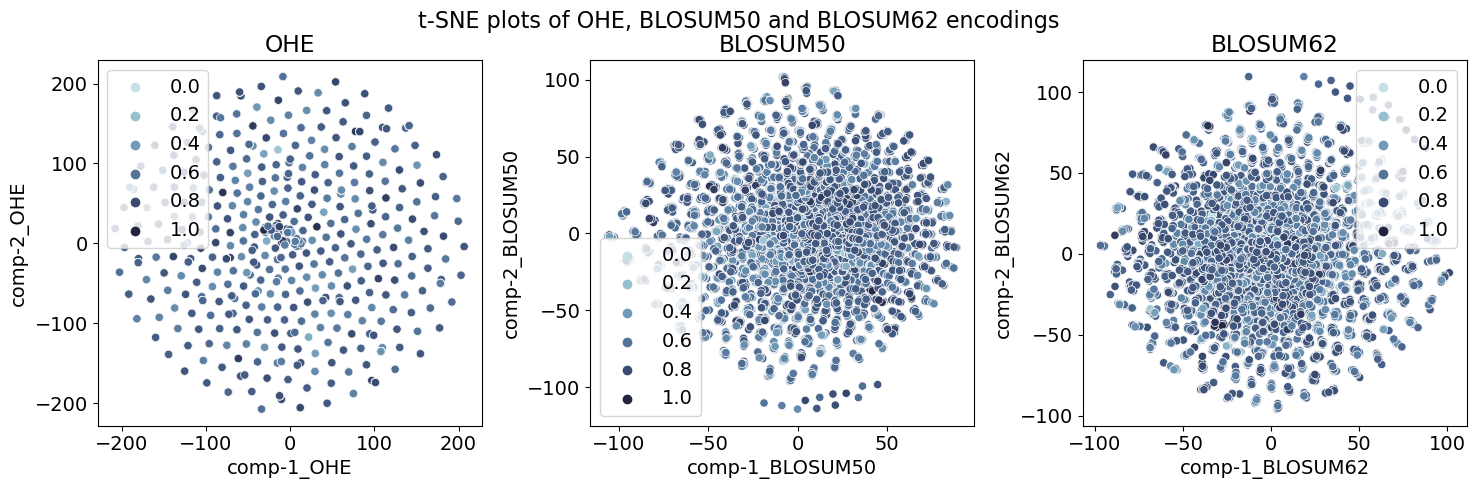

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a 1x3 grid of subplots

encoding_types = ['OHE', 'BLOSUM50', 'BLOSUM62']
for i, encoding_type in enumerate(encoding_types):
    if encoding_type == 'OHE':
        seq_reps = torch_tools.one_hot_encoder(seqs)
    else:
        seq_reps = torch_tools.blosum_encoding(seqs, matrix=encoding_type)

    seq_reps = seq_reps.reshape(seq_reps.shape[0], -1)

    tsne = TSNE(n_components=2, verbose=1, random_state=42)
    z = tsne.fit_transform(seq_reps) 

    enc_df["y"] = enc_df.y.to_list()
    enc_df[f"comp-1_{encoding_type}"] = z[:,0]
    enc_df[f"comp-2_{encoding_type}"] = z[:,1]

    cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
    sns.scatterplot(x=f"comp-1_{encoding_type}", y=f"comp-2_{encoding_type}", hue=enc_df.y.tolist(),
                    palette=cmap,
                    data=enc_df, ax=axs[i]).set(title=encoding_type) 

plt.tight_layout()  # Adjust the layout to avoid overlapping
fig.suptitle('t-SNE plots of OHE, BLOSUM50 and BLOSUM62 encodings', fontsize=16)
plt.subplots_adjust(top=0.88)
plt.savefig(f'{dat}_tsne_simple')
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6227 samples in 0.000s...
[t-SNE] Computed neighbors for 6227 samples in 0.207s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6227
[t-SNE] Computed conditional probabilities for sample 2000 / 6227
[t-SNE] Computed conditional probabilities for sample 3000 / 6227
[t-SNE] Computed conditional probabilities for sample 4000 / 6227
[t-SNE] Computed conditional probabilities for sample 5000 / 6227
[t-SNE] Computed conditional probabilities for sample 6000 / 6227
[t-SNE] Computed conditional probabilities for sample 6227 / 6227
[t-SNE] Mean sigma: 0.017673
[t-SNE] KL divergence after 50 iterations with early exaggeration: 89.726242
[t-SNE] KL divergence after 1000 iterations: 2.295020
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6227 samples in 0.000s...
[t-SNE] Computed neighbors for 6227 samples in 0.206s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6227
[t-SNE] Computed conditional p

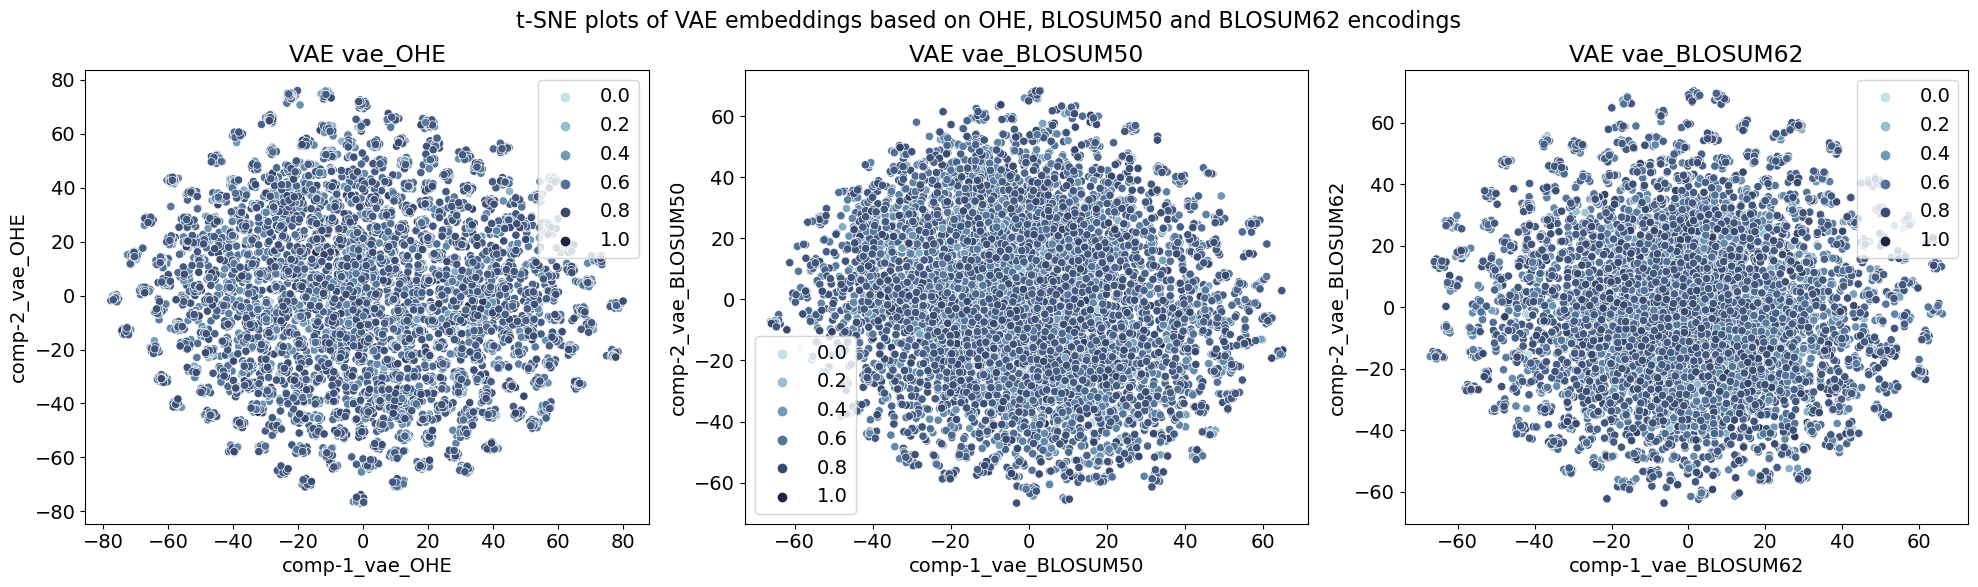

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # Create a 1x3 grid of subplots

encoding_types = ['vae_OHE', 'vae_BLOSUM50', 'vae_BLOSUM62']
for i, encoding_type in enumerate(encoding_types):
    _, seq_reps = io_tools.embeddings.load_embeddings(os.path.join(representations_path, f'{encoding_type}/{dat}'))
    seq_reps = np.array([x.numpy() for x in seq_reps])

    tsne = TSNE(n_components=2, verbose=1, random_state=42)
    z = tsne.fit_transform(seq_reps)

    enc_df["y"] = enc_df.y.to_list()
    enc_df[f"comp-1_{encoding_type}"] = z[:, 0]
    enc_df[f"comp-2_{encoding_type}"] = z[:, 1]

    cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
    sns.scatterplot(x=f"comp-1_{encoding_type}", y=f"comp-2_{encoding_type}", hue=enc_df.y.tolist(),
                    palette=cmap,
                    data=enc_df, ax=axs[i]).set(title=f"VAE {encoding_type}")

plt.tight_layout()  # Adjust the layout to avoid overlapping
fig.suptitle('t-SNE plots of VAE embeddings based on OHE, BLOSUM50 and BLOSUM62 encodings', fontsize=16)
plt.subplots_adjust(top=0.88)
plt.savefig(f'{dat}_tsne_VAE')
plt.show()


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6227 samples in 0.002s...
[t-SNE] Computed neighbors for 6227 samples in 0.794s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6227
[t-SNE] Computed conditional probabilities for sample 2000 / 6227
[t-SNE] Computed conditional probabilities for sample 3000 / 6227
[t-SNE] Computed conditional probabilities for sample 4000 / 6227
[t-SNE] Computed conditional probabilities for sample 5000 / 6227
[t-SNE] Computed conditional probabilities for sample 6000 / 6227
[t-SNE] Computed conditional probabilities for sample 6227 / 6227
[t-SNE] Mean sigma: 0.049451
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.000313
[t-SNE] KL divergence after 1000 iterations: 1.583201
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6227 samples in 0.002s...
[t-SNE] Computed neighbors for 6227 samples in 0.806s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6227
[t-SNE] Computed conditional 

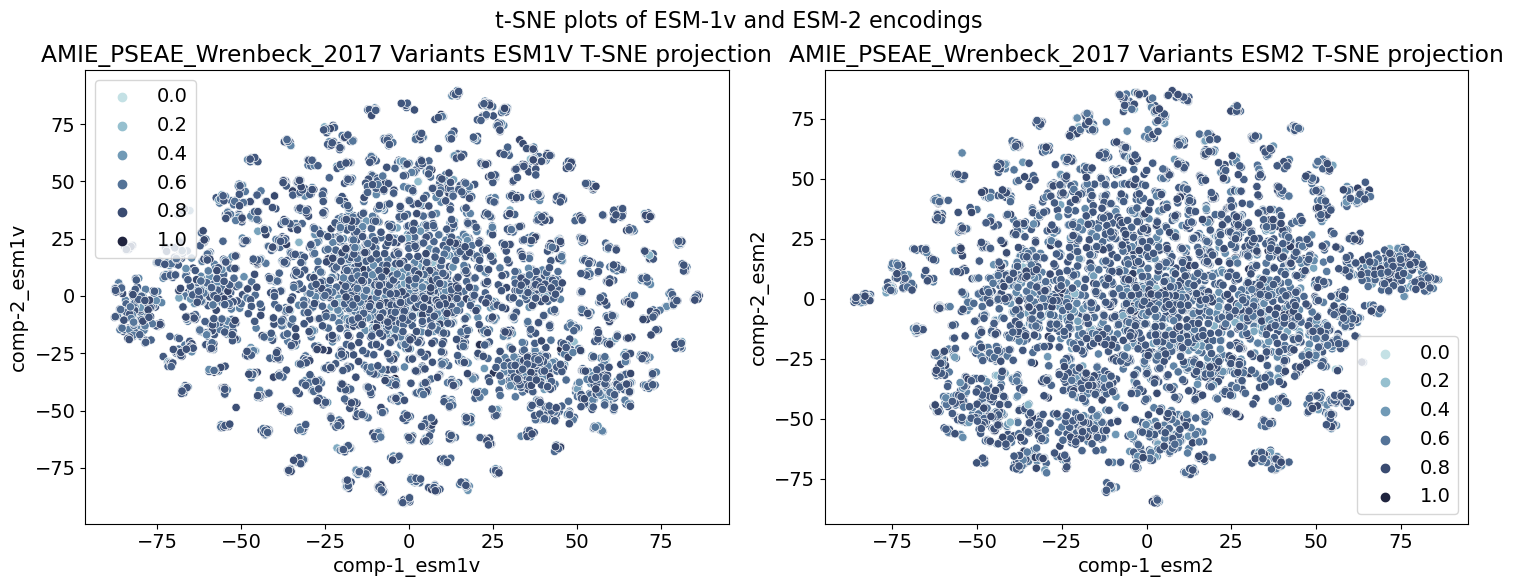

In [62]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Create a 1x2 grid of subplots

encoding_types = ['esm1v', 'esm2']
for i, encoding_type in enumerate(encoding_types):
    _, seq_reps = io_tools.embeddings.load_embeddings(os.path.join(representations_path, f'{encoding_type}/{dat}'))
    enc_df[encoding_type] = [x.numpy() for x in seq_reps]
    seq_reps = np.array(enc_df[encoding_type].to_list())

    tsne = TSNE(n_components=2, verbose=1, random_state=42)
    z = tsne.fit_transform(seq_reps)

    enc_df["y"] = enc_df.y.to_list()
    enc_df[f"comp-1_{encoding_type}"] = z[:, 0]
    enc_df[f"comp-2_{encoding_type}"] = z[:, 1]

    cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
    sns.scatterplot(x=f"comp-1_{encoding_type}", y=f"comp-2_{encoding_type}", hue=enc_df.y.tolist(),
                    palette=cmap,
                    data=enc_df, ax=axs[i]).set(title=f"{dat} Variants {encoding_type.upper()} T-SNE projection")

plt.tight_layout()  # Adjust the layout to avoid overlapping
fig.suptitle('t-SNE plots of ESM-1v and ESM-2 encodings', fontsize=16)
plt.subplots_adjust(top=0.88)
plt.savefig(f'{dat}_tsne_ESM')
plt.show()

In [63]:
enc_df

mutant                                   mutated_sequence  DMS_score  \
0       M1H  HRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...    -0.4445   
1       M1V  VRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...    -0.3485   
2       M1T  TRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...    -0.4680   
3       M1S  SRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...    -0.5564   
4       M1R  RRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...    -0.6121   
...     ...                                                ...        ...   
6222  G341R  MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...    -0.0193   
6223  G341S  MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...    -0.0722   
6224  G341V  MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...    -0.0471   
6225  G341W  MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...     0.0666   
6226  G341T  MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...    -0.0547   

      DMS_score_bin         y  comp-1_OHE  comp-2_OHE  comp-1_BLOSUM50  \
0                 0  0.587427    8.828764   -0.703447        19.090235   
1                 0  0.618171   10.375929    3.089703        16.999311   
2                 0  0.579901   10.375929    3.089703        18.165678   
3                 0  0.551592   10.375929    3.089703        18.346167   
4                 0  0.533754    8.828764   -0.703447        18.421627   
...             ...       ...         ...         ...              ...   
6222              1  0.723596  163.524780   -6.814763        -3.231274   
6223              1  0.706655  163.524780   -6.814763        -1.497604   
6224              1  0.714693  163.524780   -6.814763         0.234983   
6225              1  0.751105  163.524780   -6.814763        -0.436912   
6226              1  0.712259  163.524780   -6.814763        -1.224433   

      comp-2_BLOSUM50  comp-1_BLOSUM62  ...  comp-1_vae_BLOSUM50  \
0           68.626701        29.186430  ...           -12.022593   
1           63.495426        15.020759  ...            23.417019   
2           66.534172        26.519848  ...           -34.248699   
3           66.812744        26.833408  ...           -26.031633   
4           68.456093        27.867184  ...            -3.508252   
...               ...              ...  ...                  ...   
6222       -40.797371        54.324821  ...           -27.910477   
6223       -39.951405        54.163879  ...           -11.616183   
6224       -41.639965        55.823204  ...           -26.431555   
6225       -43.219791        57.589397  ...             3.252665   
6226       -40.075481        54.336609  ...           -52.448730   

      comp-2_vae_BLOSUM50  comp-1_vae_BLOSUM62  comp-2_vae_BLOSUM62  \
0              -11.834436             3.566792             6.566524   
1              -22.429937             5.981214            38.862793   
2              -20.588215             6.624531           -30.311605   
3               27.013477            45.885010            15.802373   
4               21.093346           -65.308258            15.628187   
...                   ...                  ...                  ...   
6222            10.568689            39.948601           -10.194502   
6223           -24.679588            14.836339             5.982253   
6224            21.864283            16.081451            22.341303   
6225            40.534252            18.887112           -35.001408   
6226            19.478943            -6.881211           -18.680197   

                                                  esm1v  comp-1_esm1v  \
0     [-0.09764214, 0.33168218, -0.077413335, 0.1101...    -50.569351   
1     [-0.10423209, 0.33440885, -0.07577298, 0.10478...     43.494244   
2     [-0.09835696, 0.33242223, -0.07805493, 0.10572...      3.840783   
3     [-0.10827764, 0.33497044, -0.073028356, 0.1111...     56.980385   
4     [-0.075997375, 0.3329333, -0.08153352, 0.10243...     22.613005   
...                                                 ...           ...   
6222  [-0.

In [64]:
def dbscan_clustering(data: pd.DataFrame, z1: str, z2: str, enc: str, eps: float, min_samples: int, use_tsne=False) -> pd.DataFrame:
    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    if use_tsne:
        dbscan.fit(np.stack(list(zip(data[z1], data[z2]))))
    else:
        dbscan.fit(np.stack(data[enc]))
    
    # Assign cluster labels to each data point
    data['dbscan-clusters'] = dbscan.labels_
    
    return data


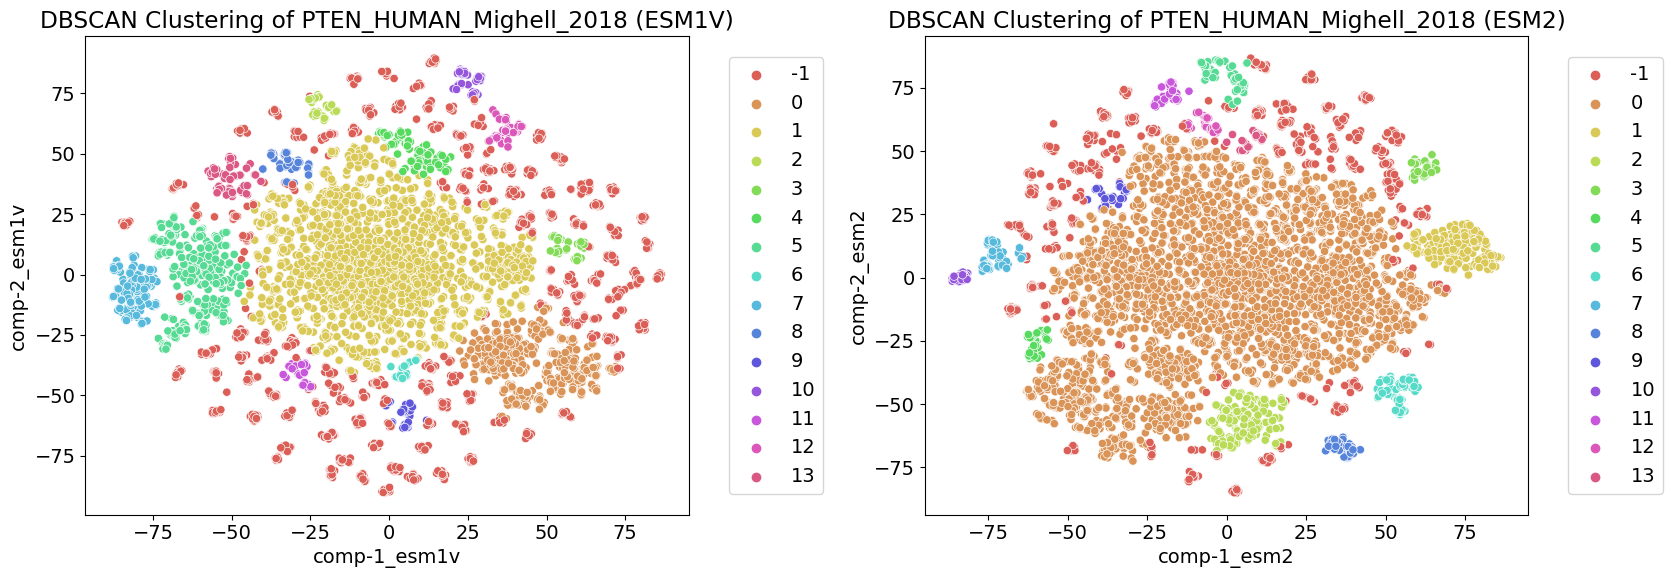

In [73]:
# Perform clustering
eps = 6
min_samples = 40
z1 = 'comp-1_esm1v'
z2 = 'comp-1_esm2'
encodings = ["esm1v", "esm2"]

fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # Create a 1x2 grid of subplots

for i, enc in enumerate(encodings):
    enc_df_dbscan = dbscan_clustering(enc_df, z1=f"comp-1_{enc}", z2=f"comp-2_{enc}", enc=enc, eps=eps, min_samples=min_samples, use_tsne=True)
    cols = len(set(enc_df_dbscan['dbscan-clusters'].tolist()))
    scatter_plot = sns.scatterplot(x=f"comp-1_{enc}", y=f"comp-2_{enc}", hue=enc_df_dbscan['dbscan-clusters'].tolist(),
                                   palette=sns.color_palette("hls", cols),
                                   data=enc_df_dbscan, ax=axs[i])
    scatter_plot.set(title=f"DBSCAN Clustering of {dat} ({enc.upper()})")
    scatter_plot.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')  # Position the legend

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to avoid overlapping
plt.savefig('clustering_esm_tsne.png')
plt.show()


In [66]:
# Initialize two empty DataFrames to store the results
avg_activity_df_esm1v = pd.DataFrame()
avg_activity_df_esm2 = pd.DataFrame()

for enc in encodings:
    # Perform DBSCAN clustering
    enc_df_dbscan = dbscan_clustering(enc_df, z1=f"comp-1_{enc}", z2=f"comp-2_{enc}", enc=enc, eps=eps, min_samples=min_samples, use_tsne=True)
    
    # Calculate the average activity in each cluster
    avg_activity = enc_df_dbscan.groupby('dbscan-clusters')['y'].mean().reset_index()
    
    # Add the encoding type as a new column
    avg_activity['encoding'] = enc
    
    # Append the results to the corresponding DataFrame
    if enc == 'esm1v':
        avg_activity_df_esm1v = avg_activity_df_esm1v.append(avg_activity, ignore_index=True)
    else:
        avg_activity_df_esm2 = avg_activity_df_esm2.append(avg_activity, ignore_index=True)

# Rename the columns for clarity
avg_activity_df_esm1v.columns = ['Cluster', 'Average Activity ESM1v', 'Encoding']
avg_activity_df_esm2.columns = ['Cluster', 'Average Activity ESM2', 'Encoding']

# Merge the DataFrames on the 'Cluster' column
merged_df = pd.merge(avg_activity_df_esm1v, avg_activity_df_esm2, on='Cluster')

# Remove the 'Encoding' columns
merged_df = merged_df.drop(['Encoding_x', 'Encoding_y'], axis=1)

# Round the values to 4 digits
merged_df = merged_df.round(4)

# Display the merged DataFrame
print("Merged Average Activity:")
print(merged_df.to_latex(index=False))


Merged Average Activity:
\begin{tabular}{rrr}
\toprule
 Cluster &  Average Activity ESM1v &  Average Activity ESM2 \\
\midrule
      -1 &                  0.6330 &                 0.6326 \\
       0 &                  0.6360 &                 0.6341 \\
       1 &                  0.6320 &                 0.6313 \\
       2 &                  0.6682 &                 0.6310 \\
       3 &                  0.6409 &                 0.6355 \\
       4 &                  0.6284 &                 0.6622 \\
       5 &                  0.6292 &                 0.6275 \\
       6 &                  0.6545 &                 0.6288 \\
       7 &                  0.6329 &                 0.6145 \\
       8 &                  0.6474 &                 0.6220 \\
       9 &                  0.6303 &                 0.6526 \\
      10 &                  0.6510 &                 0.6334 \\
      11 &                  0.6329 &                 0.6019 \\
      12 &                  0.6606 &                 0

/var/folders/sd/pr3fylj57wlgrmcxg1v4zp3c0000gn/T/ipykernel_51018/1651570778.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  avg_activity_df_esm1v = avg_activity_df_esm1v.append(avg_activity, ignore_index=True)
/var/folders/sd/pr3fylj57wlgrmcxg1v4zp3c0000gn/T/ipykernel_51018/1651570778.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  avg_activity_df_esm2 = avg_activity_df_esm2.append(avg_activity, ignore_index=True)
/var/folders/sd/pr3fylj57wlgrmcxg1v4zp3c0000gn/T/ipykernel_51018/1651570778.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  prin

In [67]:
# Perform DBSCAN clustering for each encoding and store the results in separate dataframes
enc_df_esm1v = dbscan_clustering(enc_df, z1='comp-1_esm1v', z2='comp-2_esm1v', enc='esm1v', eps=eps, min_samples=min_samples, use_tsne=True)
enc_df_esm2 = dbscan_clustering(enc_df, z1='comp-1_esm2', z2='comp-2_esm2', enc='esm2', eps=eps, min_samples=min_samples, use_tsne=True)

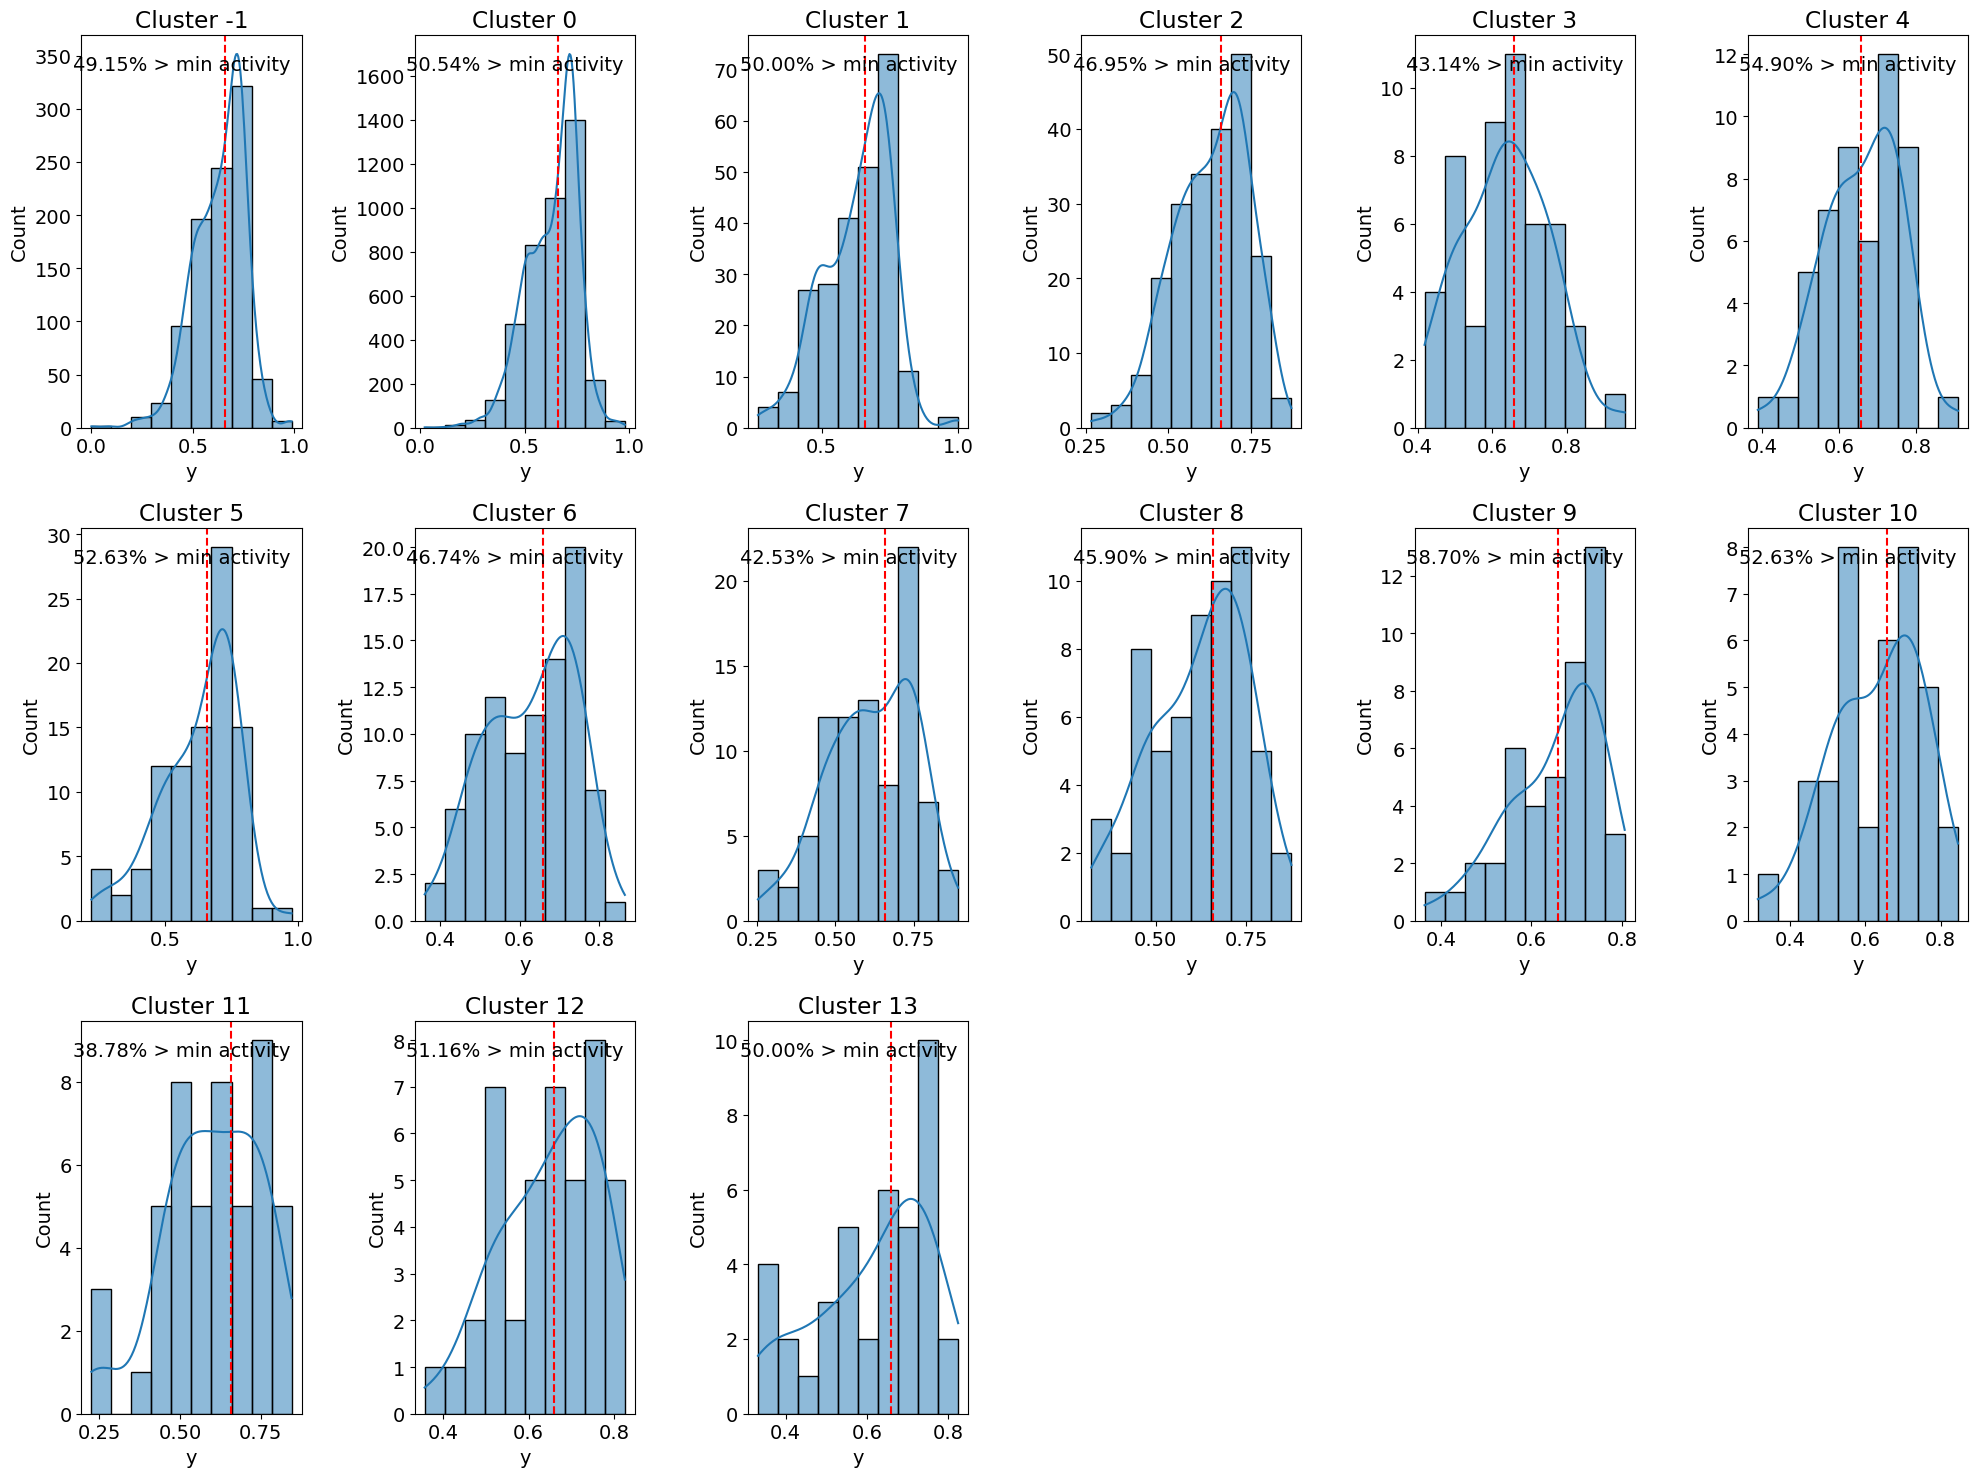

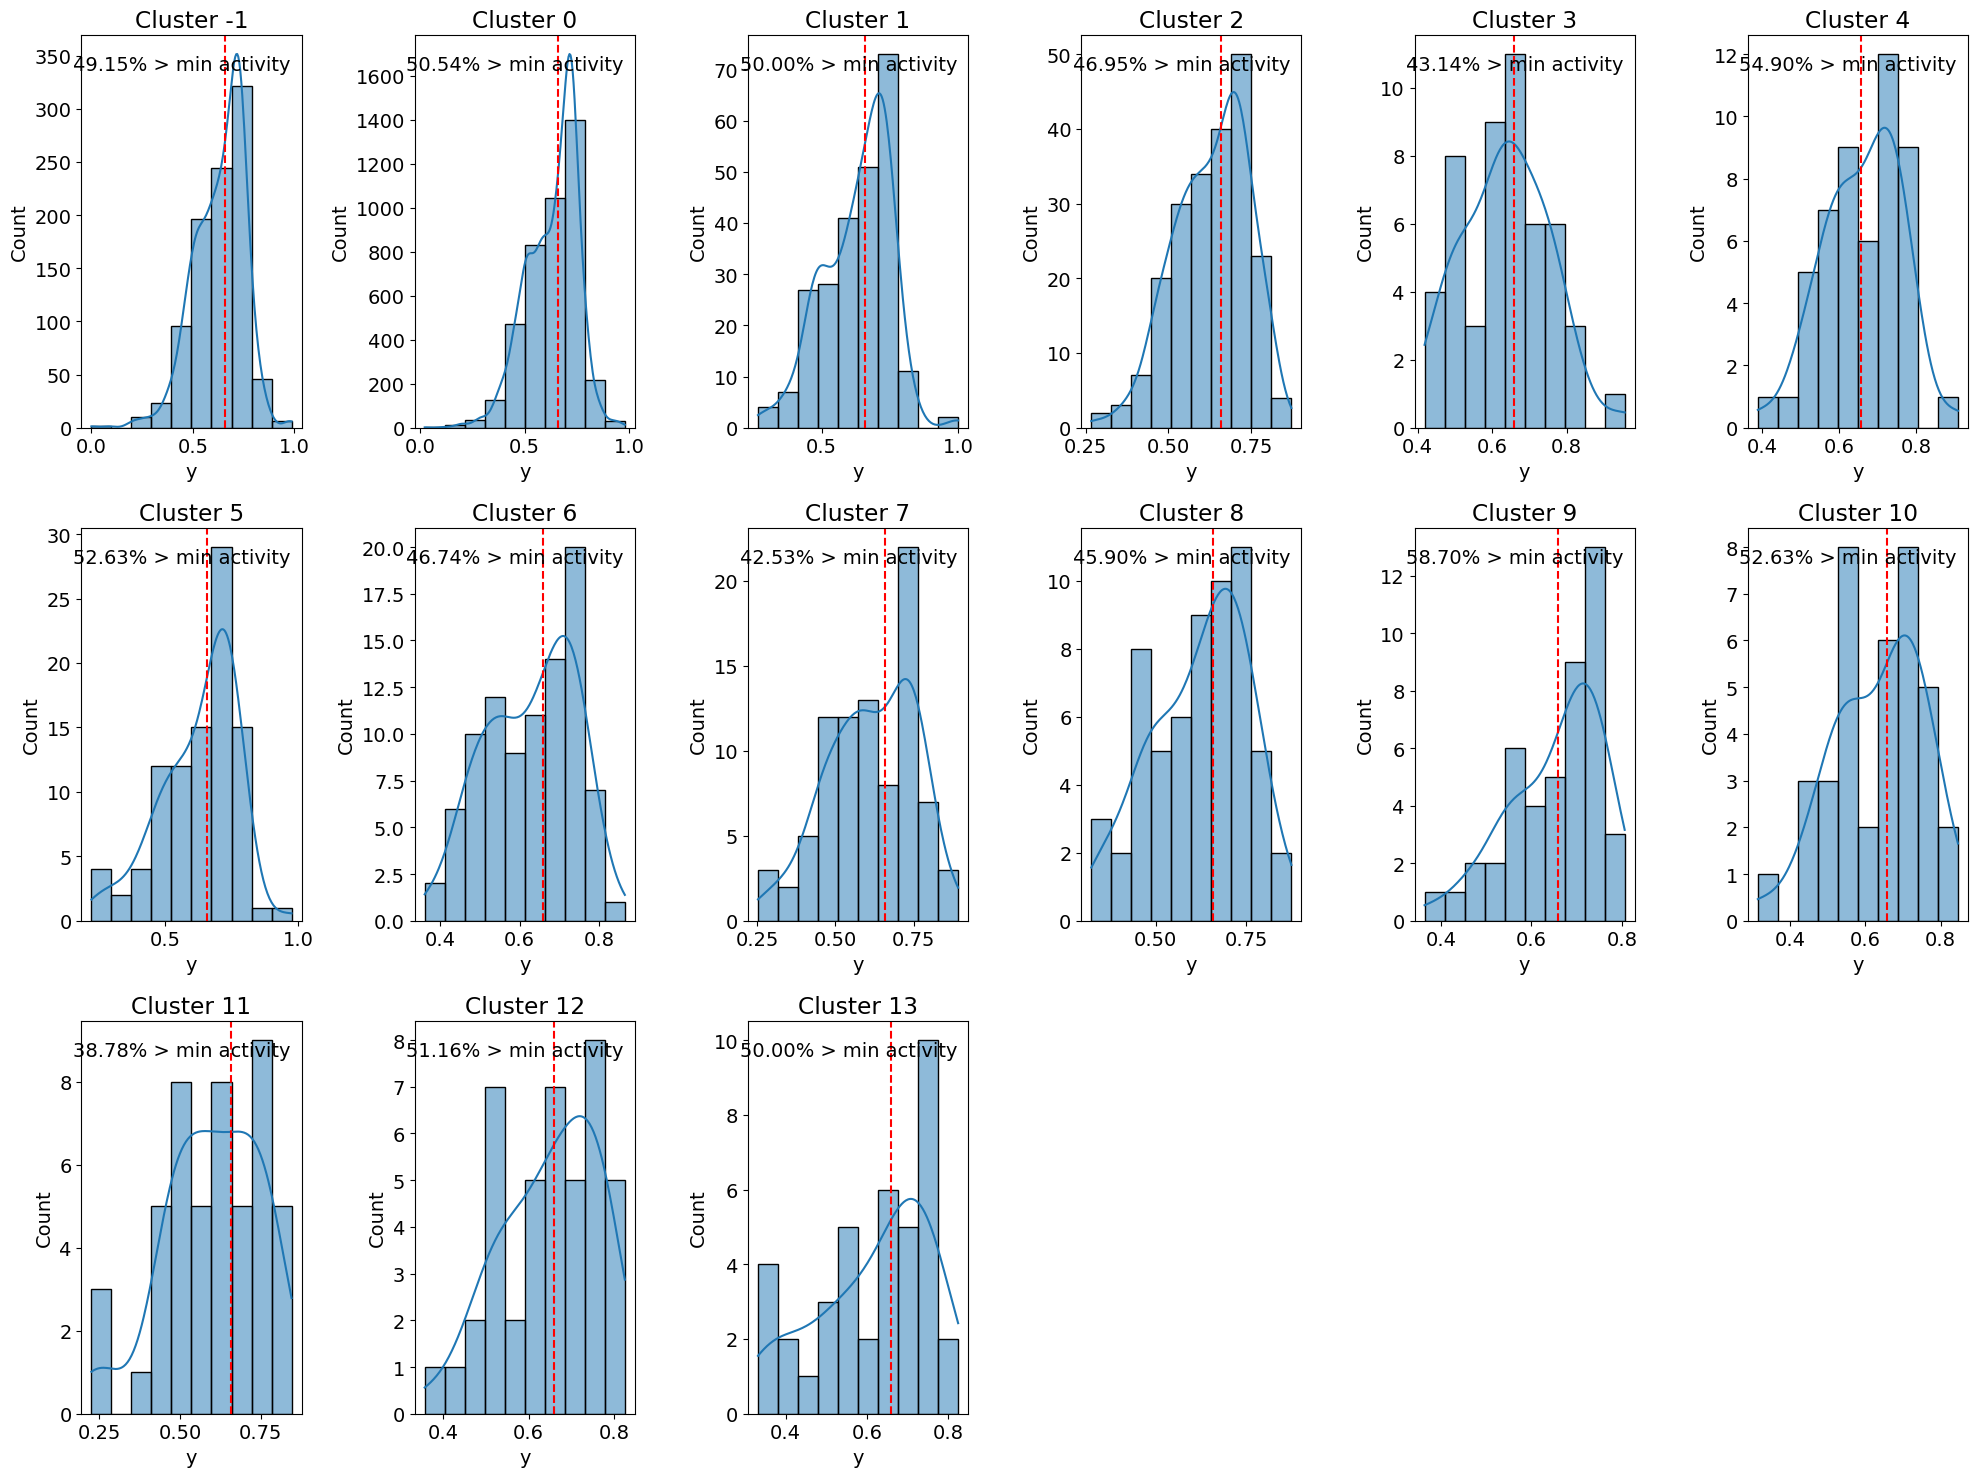

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

# Define the number of bins
num_bins = 10

# Define the number of columns in the grid
grid_cols = 6

for enc, df in zip(['esm1v', 'esm2'], [enc_df_esm1v, enc_df_esm2]):
    # Get the number of unique clusters
    num_clusters = df['dbscan-clusters'].nunique()

    # Calculate the number of rows in the grid
    grid_rows = math.ceil(num_clusters / grid_cols)

    # Create a grid of subplots
    fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(20, 5*grid_rows))

    # Flatten the axes array for easy iteration
    axs = axs.flatten()

    # Find the lowest 'DMS_score_bin' value in the dataframe
    min_DMS_score_bin = df[df['DMS_score_bin'] == 1]['y'].min()
    clusters = df['dbscan-clusters'].unique()
    clusters.sort()

    # Create a histogram for each cluster
    for i, cluster in enumerate(clusters):
        # Select the activities for the current cluster
        cluster_activities = df[df['dbscan-clusters'] == cluster]['y']

        # Create the histogram with the specified number of bins
        sns.histplot(cluster_activities, ax=axs[i], kde=True, bins=num_bins)

        # Add a vertical line at the mean value of 'y'
        axs[i].axvline(min_DMS_score_bin, color='r', linestyle='--')

        # Calculate the percentage of samples that are above the mean
        above_mean_percentage = (cluster_activities > min_DMS_score_bin).mean() * 100

        # Add the percentage to the top right of the plot
        axs[i].text(0.95, 0.95, f'{above_mean_percentage:.2f}% > min activity', transform=axs[i].transAxes, 
                    verticalalignment='top', horizontalalignment='right')

        # Set the title of the subplot
        axs[i].set_title(f'Cluster {cluster}')

        # Save the x-axis limits
        xlim = axs[i].get_xlim()


    # Remove empty subplots
    for i in range(num_clusters, grid_rows*grid_cols):
        fig.delaxes(axs[i])

    # Adjust the layout to avoid overlapping
    plt.tight_layout()
    plt.savefig(f'Cluster_activity_distribution_{enc}.png')

    # Show the plot
    plt.show()


# Chapter 2.1: Regression performance
---
Regression models built both with support vector machines and feed forward neural networks. These results will also be visualized

## Grid search parameters

In [69]:
import pandas as pd

# Your parameter grid
param_grid = {
    'C': [0.1, 1, 2, 5, 10, 100, 200, 400],
    'gamma': ['scale'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3],
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(param_grid, orient='index')

# Print the DataFrame as a LaTeX table
print(df.to_latex())

\begin{tabular}{lllllrrrr}
\toprule
{} &       0 &     1 &     2 &        3 &     4 &      5 &      6 &      7 \\
\midrule
C      &     0.1 &     1 &     2 &        5 &  10.0 &  100.0 &  200.0 &  400.0 \\
gamma  &   scale &  None &  None &     None &   NaN &    NaN &    NaN &    NaN \\
kernel &  linear &  poly &   rbf &  sigmoid &   NaN &    NaN &    NaN &    NaN \\
degree &       3 &  None &  None &     None &   NaN &    NaN &    NaN &    NaN \\
\bottomrule
\end{tabular}



/var/folders/sd/pr3fylj57wlgrmcxg1v4zp3c0000gn/T/ipykernel_51018/2676410119.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


## Analyzing the model parameters

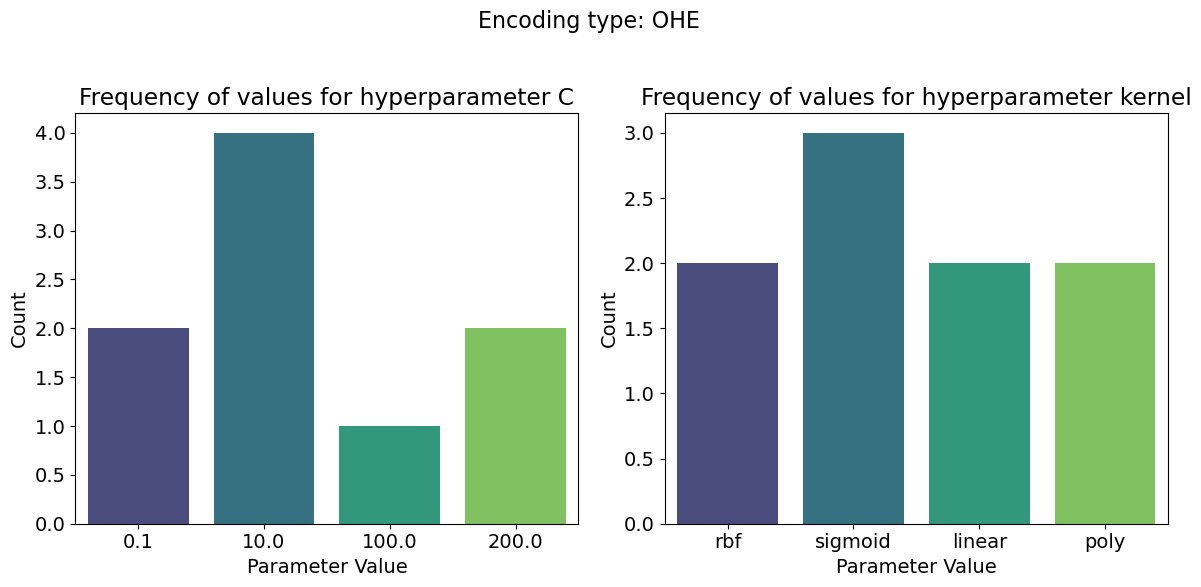

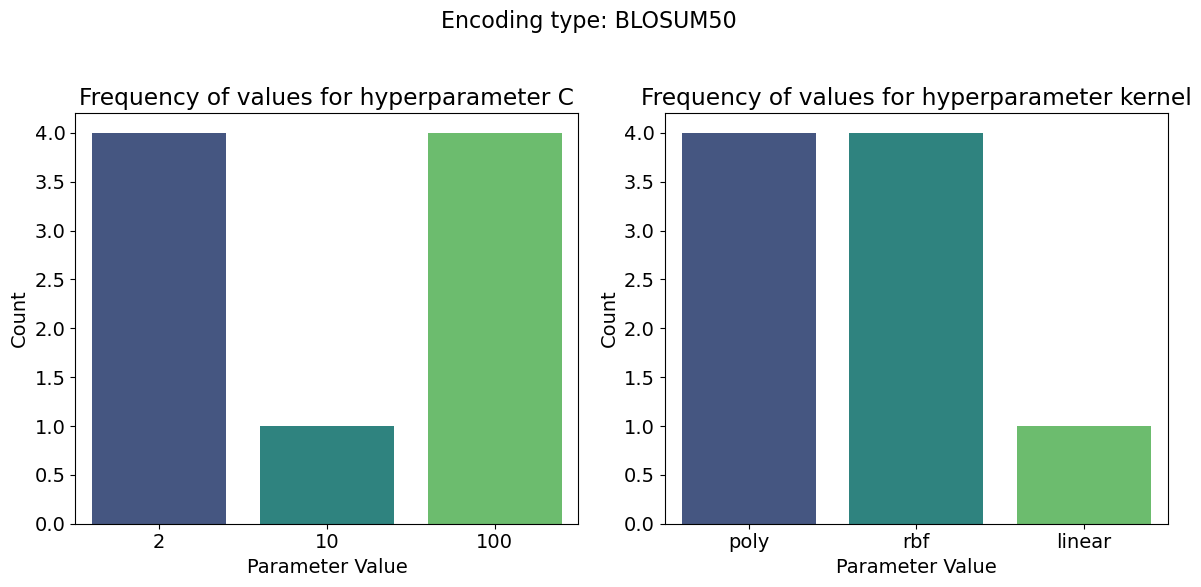

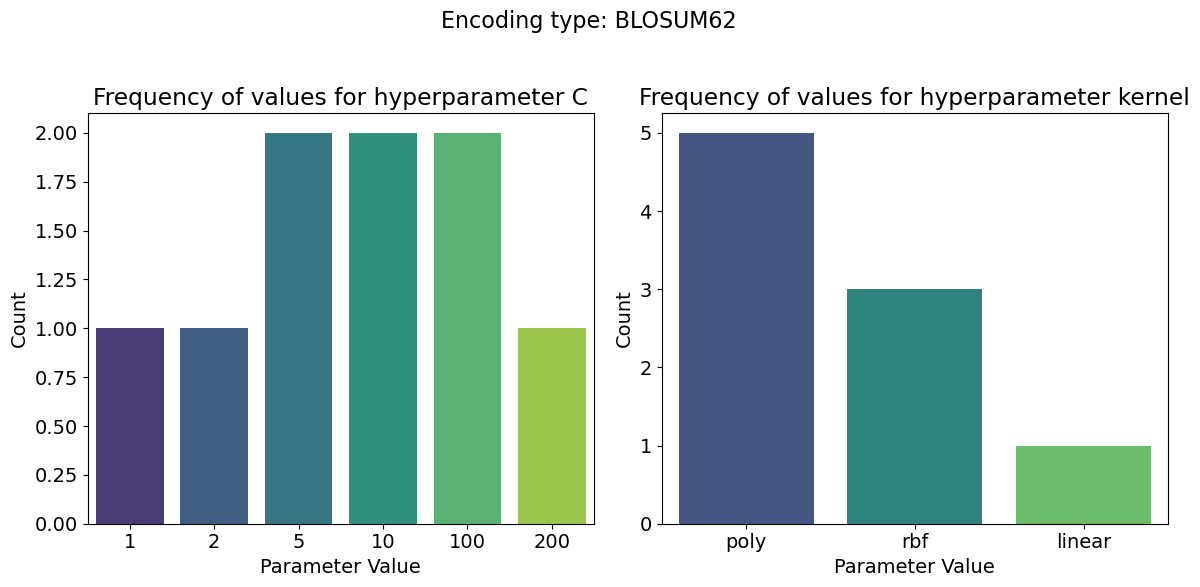

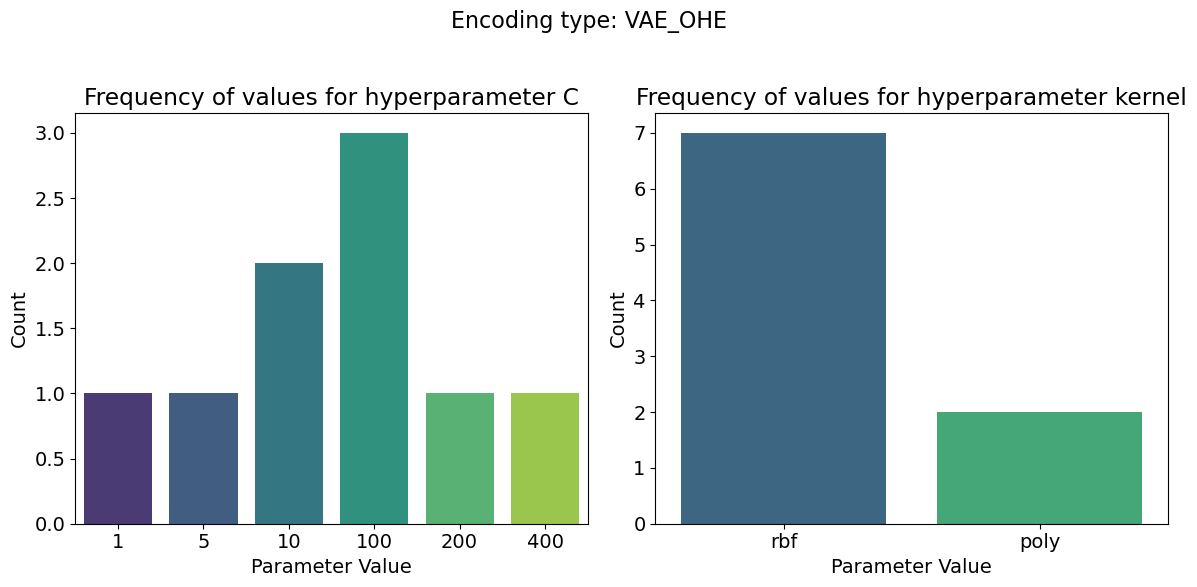

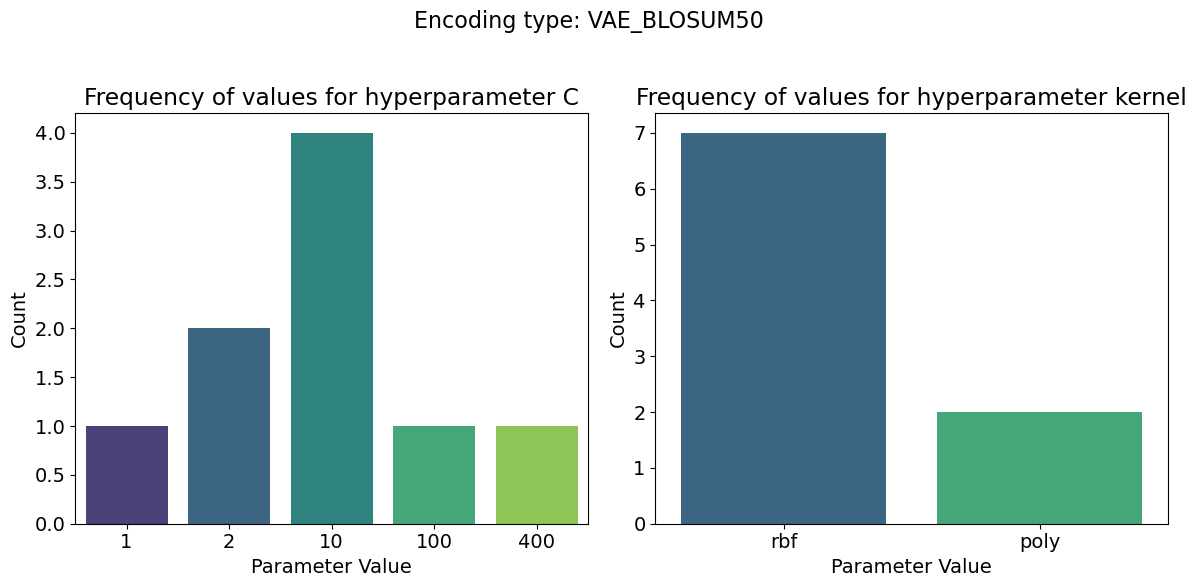

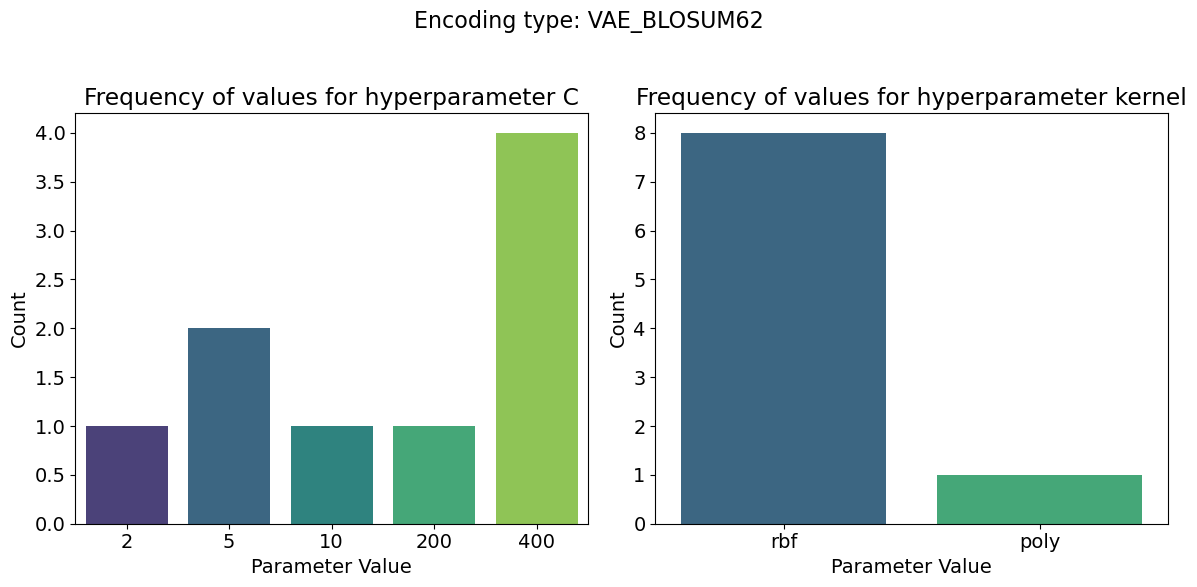

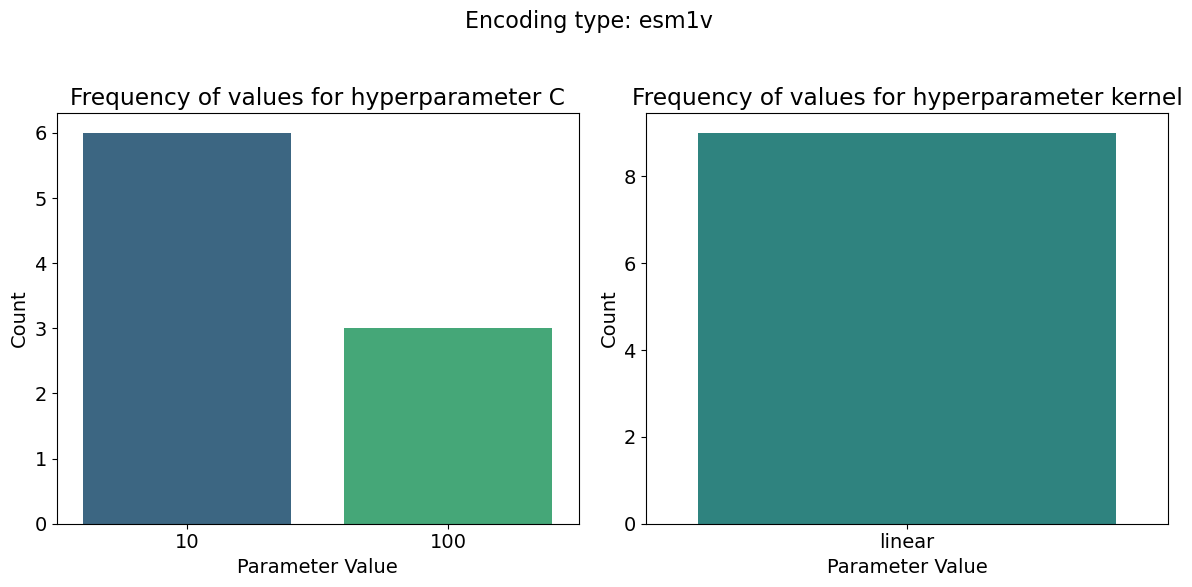

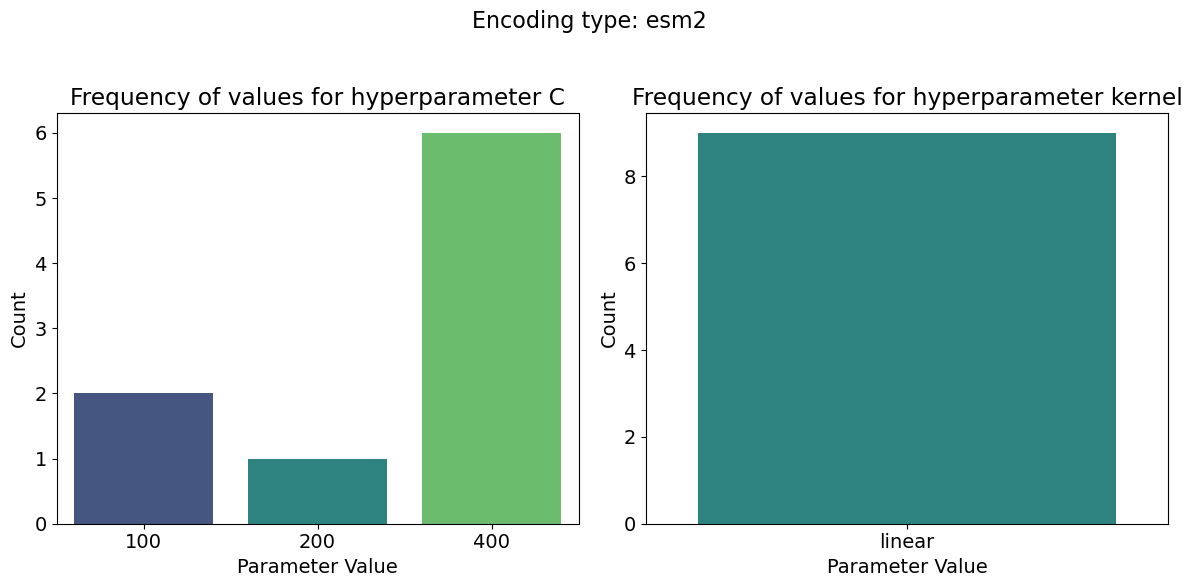

In [70]:
hyperparam_names = ['C', 'kernel']
encoding_types = ['OHE', 'BLOSUM50', 'BLOSUM62', 'VAE_OHE', 'VAE_BLOSUM50', 'VAE_BLOSUM62', 'esm1v', 'esm2']

# Initialize a dictionary to store the Counter for each hyperparameter and encoding type
hyperparam_counts = {et: {hp: Counter() for hp in hyperparam_names} for et in encoding_types}

# Iterate over each encoding type and dataset
for et in encoding_types:
    for dat in datasets:
        # Construct the filename
        filename = os.path.join(results_path, f'{dat}_svr_{et}_best_params.json')
        
        try:
            # Load the JSON file
            with open(filename) as f:
                best_params = json.load(f)

            # Update the parameter counter for 'kernel' and 'C'
            for hp in hyperparam_names:
                if hp in best_params:
                    hyperparam_counts[et][hp][best_params[hp]] += 1
        except FileNotFoundError:
            print(f"File {filename} not found.")
            
# Create bar plots for each encoding type
for et in encoding_types:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Create one subplot for each hyperparameter
    for i, (hp, counter) in enumerate(hyperparam_counts[et].items()):
        # Convert the counter to a DataFrame
        df = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
        df = df.reset_index().rename(columns={'index': 'param_value'})
        
        # Create the bar plot
        sns.barplot(x='param_value', y='count', data=df, palette="viridis", ax=axs[i])
        axs[i].set_title(f'Frequency of values for hyperparameter {hp}')
        axs[i].set_ylabel('Count')
        axs[i].set_xlabel('Parameter Value')
        
    # Set the main title for the subplots
    fig.suptitle(f'Encoding type: {et}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the whitespace between the subplots
    plt.show()


In [71]:
# Create an empty DataFrame to store all the data
all_data = pd.DataFrame()

# Iterate over each encoding type and hyperparameter
for et in encoding_types:
    for hp in ['C', 'kernel']:  # Limit to the specified parameters
        # Convert the counter to a DataFrame
        df = pd.DataFrame.from_dict(hyperparam_counts[et][hp], orient='index', columns=['count'])
        df['param_value'] = df.index
        df['param_type'] = hp  # Add the parameter type as a column

        # Add the encoding type as a column
        df['encoding_type'] = et

        # Append the data to the main DataFrame
        all_data = pd.concat([all_data, df])

# Reset the index
all_data = all_data.reset_index(drop=True)

# Create a pivot table with multi-index columns
pivot_table = pd.pivot_table(all_data, values='count', index=['encoding_type'],
                             columns=['param_type', 'param_value'], fill_value=0)

# Print the pivot table as a LaTeX table
print(pivot_table.to_latex(index=True, multirow=True))


\begin{tabular}{lrrrrrrrrrrrr}
\toprule
param\_type & \multicolumn{8}{l}{C} & \multicolumn{4}{l}{kernel} \\
param\_value & 0.1 &  1 &  2 &  5 & 10.0 & 100.0 & 200.0 & 400 & linear & poly & rbf & sigmoid \\
encoding\_type &     &    &    &    &      &       &       &     &        &      &     &         \\
\midrule
BLOSUM50      &   0 &  0 &  4 &  0 &    1 &     4 &     0 &   0 &      1 &    4 &   4 &       0 \\
BLOSUM62      &   0 &  1 &  1 &  2 &    2 &     2 &     1 &   0 &      1 &    5 &   3 &       0 \\
OHE           &   2 &  0 &  0 &  0 &    4 &     1 &     2 &   0 &      2 &    2 &   2 &       3 \\
VAE\_BLOSUM50  &   0 &  1 &  2 &  0 &    4 &     1 &     0 &   1 &      0 &    2 &   7 &       0 \\
VAE\_BLOSUM62  &   0 &  0 &  1 &  2 &    1 &     0 &     1 &   4 &      0 &    1 &   8 &       0 \\
VAE\_OHE       &   0 &  1 &  0 &  1 &    2 &     3 &     1 &   1 &      0 &    2 &   7 &       0 \\
esm1v         &   0 &  0 &  0 &  0 &    6 &     3 &     0 &   0 &      9 &    0 &   0 & 

/var/folders/sd/pr3fylj57wlgrmcxg1v4zp3c0000gn/T/ipykernel_51018/754516677.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pivot_table.to_latex(index=True, multirow=True))


## Taking a look at the predictions

OHE
OHE
BLOSUM50
BLOSUM62
VAE_OHE
VAE_BLOSUM50
VAE_BLOSUM62
esm1v
esm2


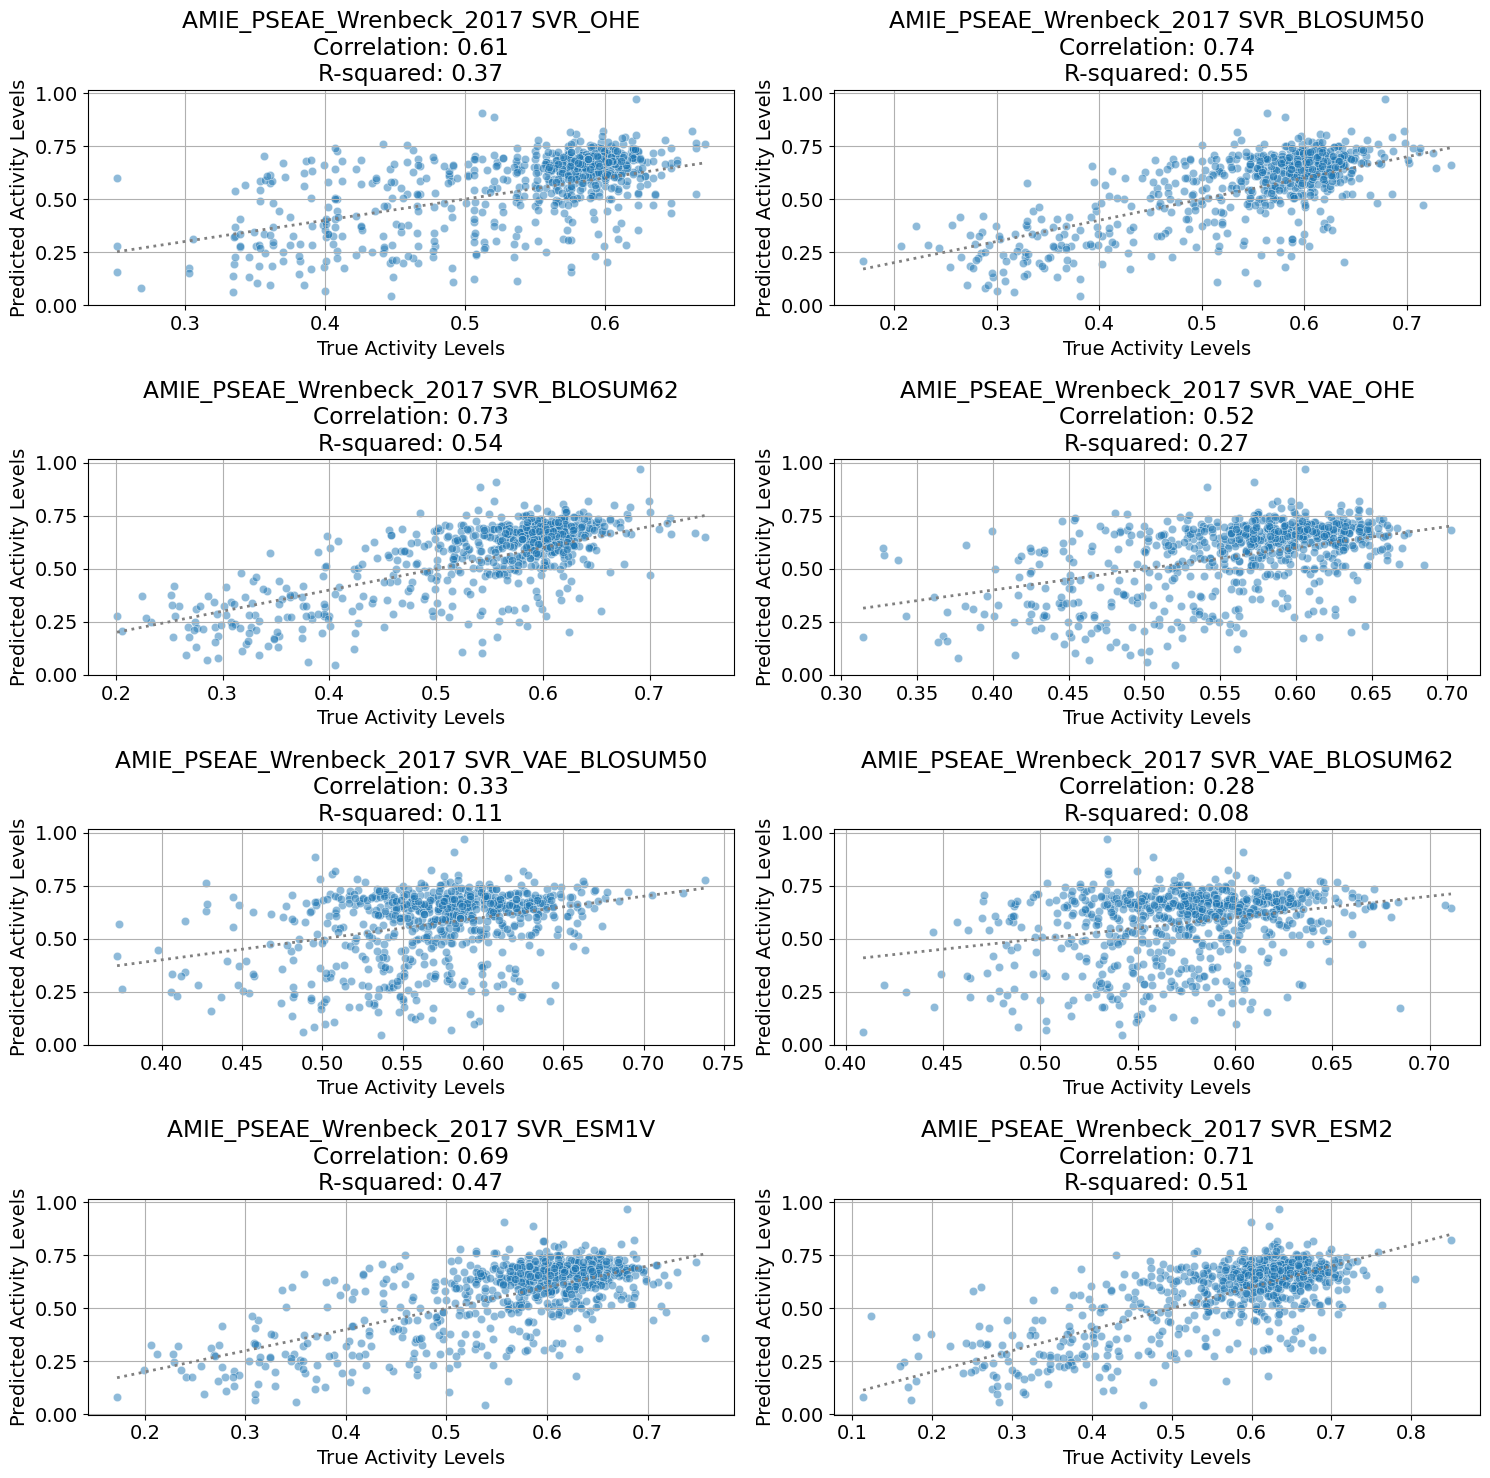

In [72]:
def plot_predictions_vs_groundtruth(ax, data, model_name):
    predictions = np.array(data['y'].to_list())
    groundtruth = np.array(data['predictions'].to_list())

    # Create the scatterplot on the given axes
    sns.scatterplot(x=groundtruth, y=predictions, alpha=0.5, ax=ax)

    # Compute Pearson correlation coefficient
    corr, _ = stats.pearsonr(groundtruth, predictions)
    r_squared = corr**2  # Compute R-squared

    # Set the plot title and labels
    ax.set_title(f'{model_name}\nCorrelation: {corr:.2f}\nR-squared: {r_squared:.2f}')
    ax.set_xlabel('True Activity Levels')
    ax.set_ylabel('Predicted Activity Levels')

    # Add the diagonal line
    ax.plot([min(groundtruth), max(groundtruth)], [min(groundtruth), max(groundtruth)], color='grey', linestyle='dotted', linewidth=2)
    
    # Fit linear regression
    coef = np.polyfit(groundtruth, predictions, 1)
    ax.grid(True)

svr_predictions = {}
study_names = []

# load results
for dat in datasets:
    for et in encoding_types:
        df = pd.read_csv(os.path.join(results_path, dat + f'_svr_{et}_predictions.csv'))
        svr_predictions[et] = df
        study_names.append(dat + f' SVR_{et.upper()}')

print(encoding_types[0])
svr_predictions[encoding_types[0]]

study = 0 * 8

fig, axs = plt.subplots(4, 2, figsize=(15, 15))  # Create a 4x2 grid of subplots
axs = axs.flatten()  # Flatten the axes array to loop over it easily

for n in range(8):
    print(encoding_types[n])
    plot_predictions_vs_groundtruth(axs[n], svr_predictions[encoding_types[n]], study_names[n+study])

plt.tight_layout()  # Adjust the layout to avoid overlapping
plt.savefig(f'{study_names[0]}_SVR_predictions.png')
plt.show()

## Collecting results

In [10]:
names = []
test_r2s = []
pearsons = []
svr_results = []
# load results
for et in encoding_types:
    for dat in datasets:
        try:
            with open(os.path.join(results_path, dat + f'_svr_{et}_results.json')) as f:
                res = json.load(f)
                name = res['name']
                if 'svr_regressor' in name:
                    name = name.replace('svr_regressor', 'svr_OHE')
                names.append(dat)
                test_r2s.append(res['test_r2'])
                pearsons.append(res['corr_coef'])
        except:
            names.append(np.na)
            test_r2s.append(np.na)
            pearsons.append(np.na)

    svr_result = pd.DataFrame({
        'name':names,
        'test_r2':test_r2s,
        'pearson':pearsons
    })
    
    svr_results.append(svr_result)
    
    names = []
    test_r2s = []
    pearsons = []

In [11]:
svr_results[6]

name   test_r2   pearson
0            AMIE_PSEAE_Wrenbeck_2017  0.504298  0.719924
1                 MSH2_HUMAN_Jia_2020  0.373815  0.619960
2   CP2C9_HUMAN_Amorosi_activity_2021  0.549741  0.747110
3            CCDB_ECOLI_Tripathi_2016  0.707837  0.842699
4  CP2C9_HUMAN_Amorosi_abundance_2021  0.580432  0.765404
5            Q59976_STRSQ_Romero_2015  0.341879  0.591336
6             SRC_HUMAN_Ahler_CD_2019  0.518205  0.736625
7             RL401_YEAST_Roscoe_2014  0.618615  0.794083
8             PTEN_HUMAN_Mighell_2018  0.470664  0.688401

## Visualize model performances

OHE
BLOSUM50
BLOSUM62
VAE OHE
VAE BLOSUM50
VAE BLOSUM62
ESM-1v
ESM-2


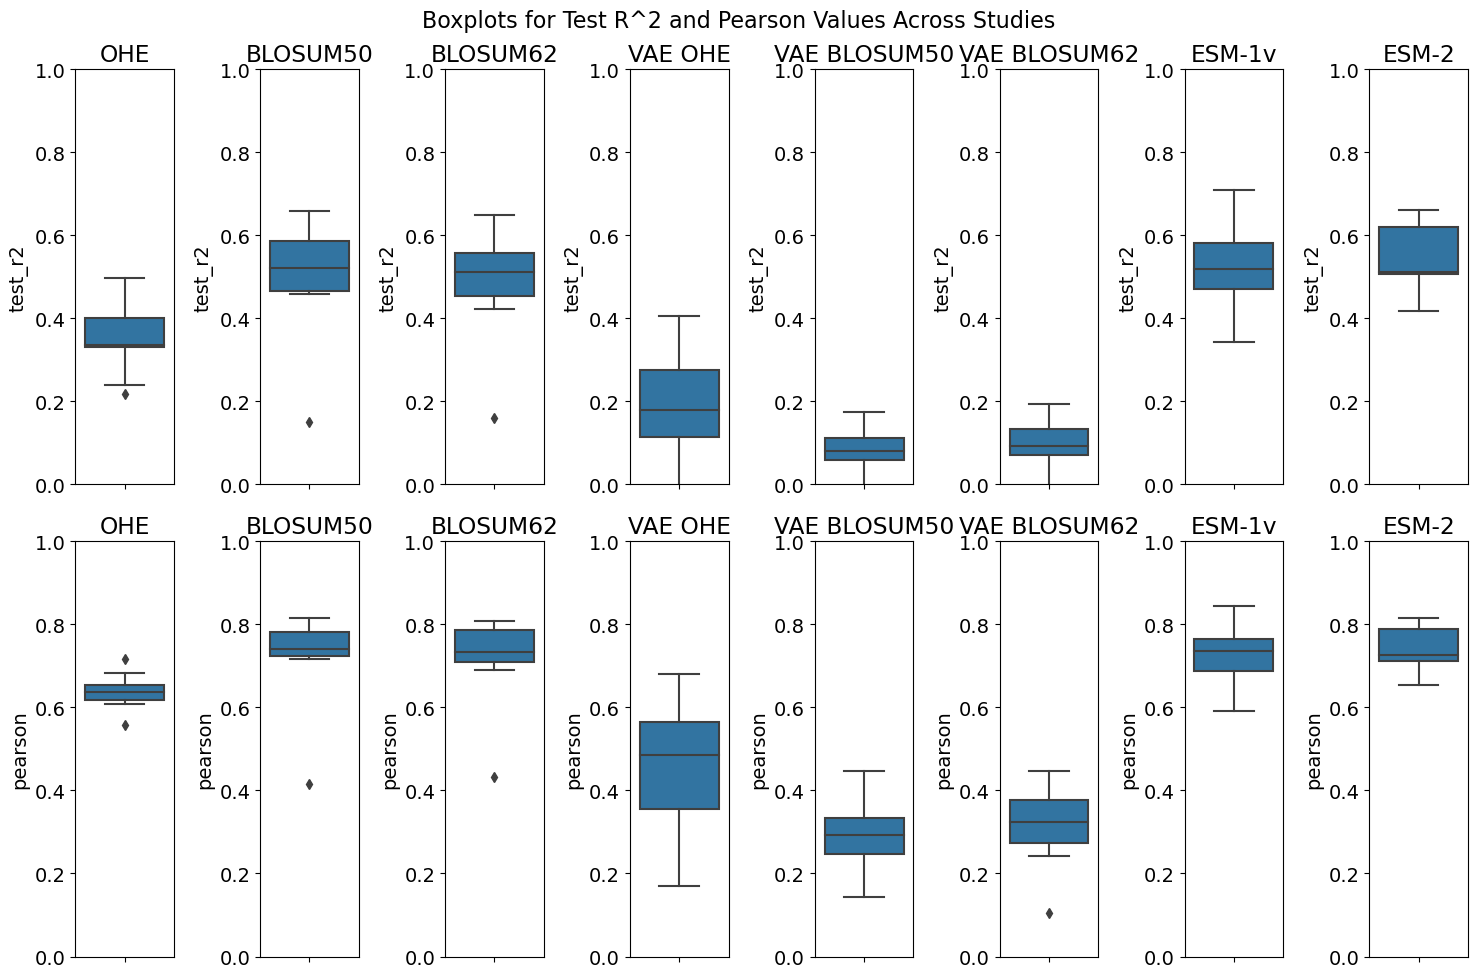

In [54]:
fig, axs = plt.subplots(2, len(encoding_types), figsize=(15, 10))  # Create a grid of subplots
encoding_names = ['OHE', 'BLOSUM50', 'BLOSUM62', 'VAE OHE', 'VAE BLOSUM50', 'VAE BLOSUM62', 'ESM-1v', 'ESM-2']
for i, encoding_type in enumerate(encoding_names):
    print(encoding_type)
    
    # Create boxplot for test_r2
    sns.boxplot(y="test_r2", data=svr_results[i], ax=axs[0, i])
    axs[0, i].set_title(f'{encoding_type}')
    axs[0, i].set_ylim(0, 1)  # Set y-axis limits

    # Create boxplot for pearson
    sns.boxplot(y="pearson", data=svr_results[i], ax=axs[1, i])
    axs[1, i].set_title(f'{encoding_type}')
    axs[1, i].set_ylim(0, 1)  # Set y-axis limits

plt.tight_layout()  # Adjust the layout to avoid overlapping
fig.suptitle('Boxplots for Test R^2 and Pearson Values Across Studies', fontsize=16)  # Add main title for the whole figure
plt.subplots_adjust(top=0.92)
plt.savefig('performance_comparisson.png')
plt.show()


In [13]:
summary_data = []

# Iterate through the results for each encoding type
for i, encoding_type in enumerate(encoding_names):
    # Extract specific data
    test_r2_data = svr_results[i]['test_r2']
    pearson_data = svr_results[i]['pearson']

    # Compute descriptive statistics
    test_r2_stats = [test_r2_data.median(), test_r2_data.std()]
    pearson_stats = [pearson_data.median(), pearson_data.std()]

    # Add the results to the summary data
    summary_data.append([encoding_type] + test_r2_stats + pearson_stats)

# Convert the summary data into a DataFrame
summary_df = pd.DataFrame(summary_data, columns=['Encoding Type', 'Test R^2 Median', 'Test R^2 Std', 'Pearson Median', 'Pearson Std'])

# Round the DataFrame to two decimal places
summary_df = summary_df.round(4)

# Print the DataFrame in LaTeX format
print(summary_df.to_latex(index=False))


\begin{tabular}{lrrrr}
\toprule
Encoding Type &  Test R\textasciicircum 2 Median &  Test R\textasciicircum 2 Std &  Pearson Median &  Pearson Std \\
\midrule
          OHE &           0.3362 &        0.0862 &          0.6356 &       0.0455 \\
     BLOSUM50 &           0.5197 &        0.1450 &          0.7407 &       0.1200 \\
     BLOSUM62 &           0.5107 &        0.1407 &          0.7341 &       0.1142 \\
      VAE OHE &           0.1780 &        0.1301 &          0.4863 &       0.1801 \\
 VAE BLOSUM50 &           0.0809 &        0.0545 &          0.2918 &       0.0864 \\
 VAE BLOSUM62 &           0.0928 &        0.0656 &          0.3248 &       0.1052 \\
       ESM-1v &           0.5182 &        0.1147 &          0.7366 &       0.0799 \\
        ESM-2 &           0.5110 &        0.0880 &          0.7258 &       0.0589 \\
\bottomrule
\end{tabular}



/var/folders/sd/pr3fylj57wlgrmcxg1v4zp3c0000gn/T/ipykernel_51018/103983362.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary_df.to_latex(index=False))


## Visualize model performances on individual studies

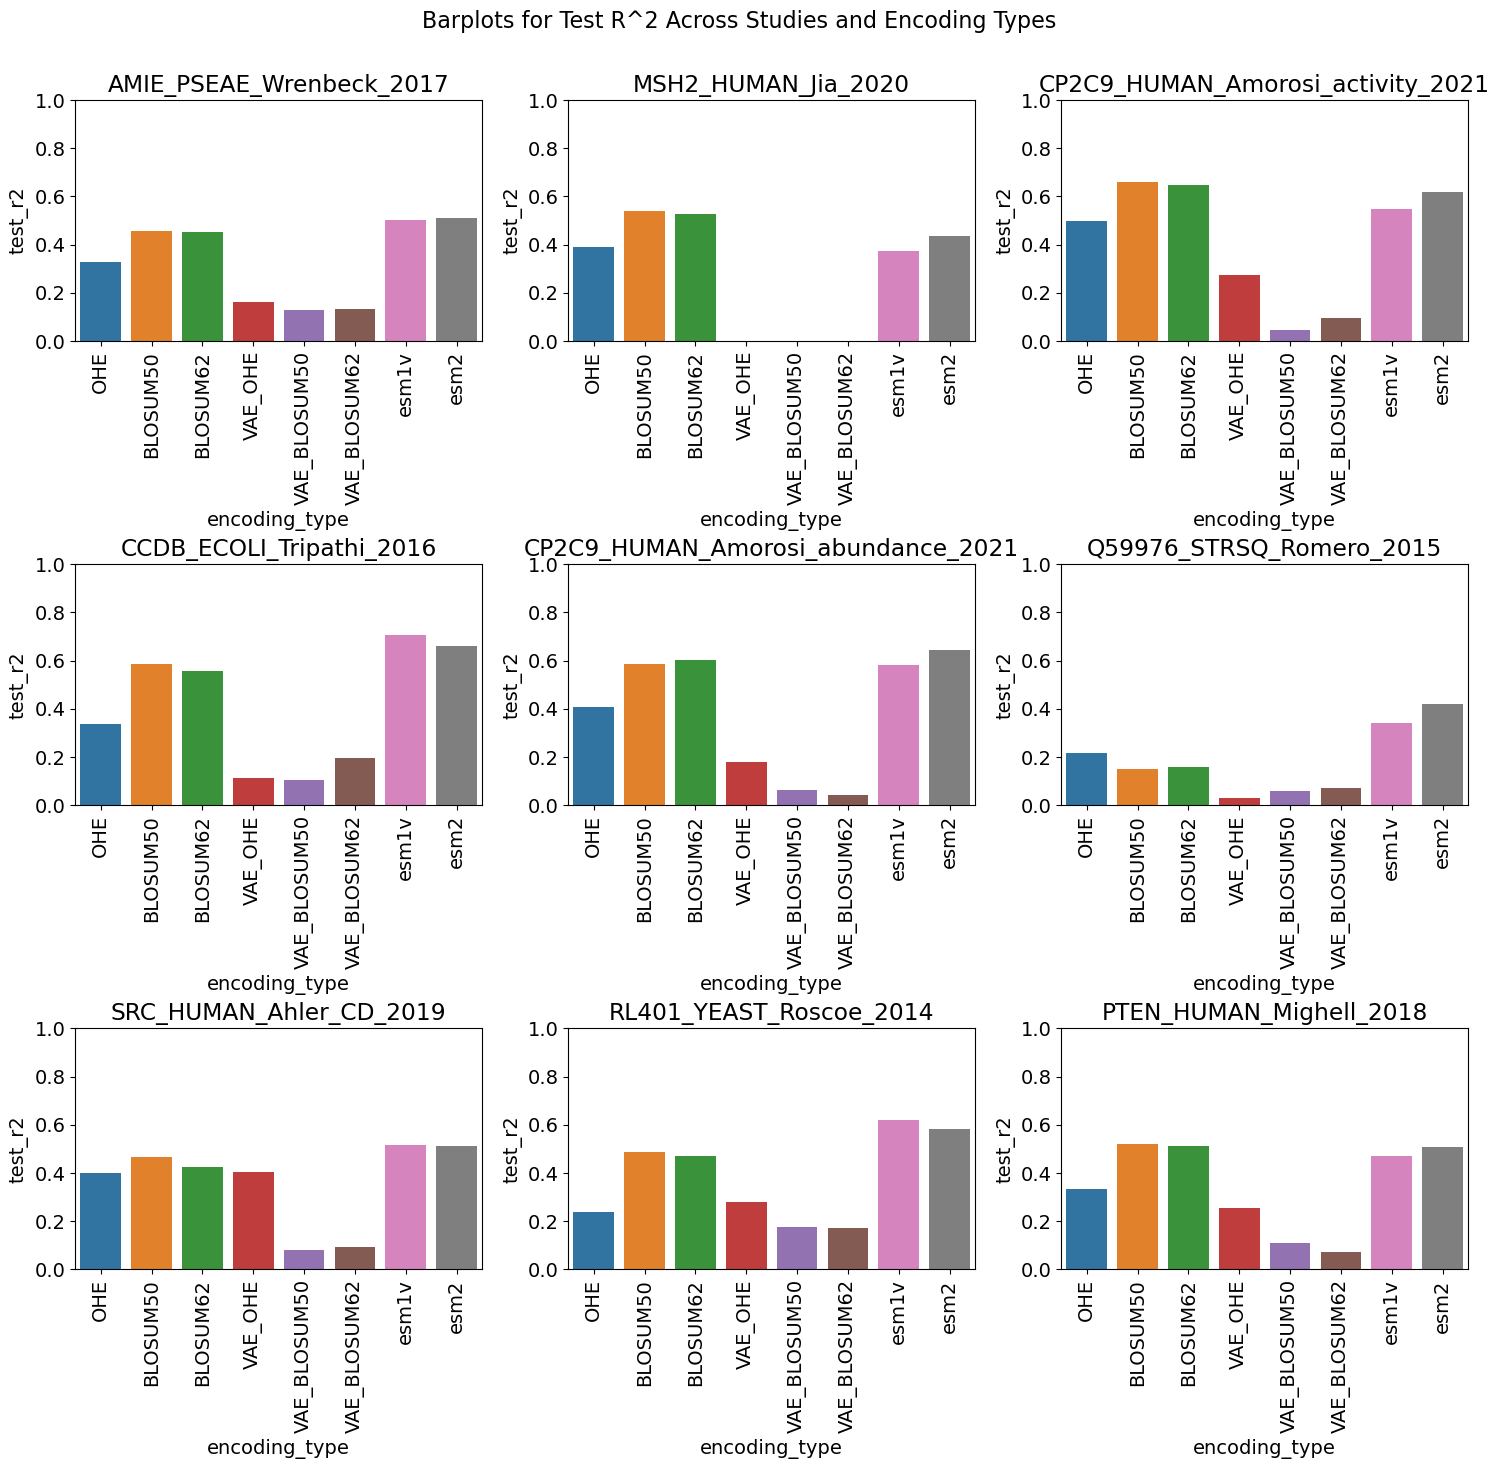

In [53]:
# Get the list of unique studies
studies = svr_results[0]['name'].unique()

# Determine the grid size for the plots
grid_size = math.ceil(math.sqrt(len(studies)))
fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))

# Iterate over each study
for s, study in enumerate(studies):
    # Create a new DataFrame to store the results for this study
    study_results = pd.DataFrame()

    # Iterate over each encoding type
    for i, encoding_type in enumerate(encoding_types):
        # Filter the results for this encoding type and this study
        encoding_results = svr_results[i].loc[svr_results[i]['name'] == study].copy()

        # Add the encoding type as a new column
        encoding_results.loc[:, 'encoding_type'] = encoding_type

        # Append the results to the study_results DataFrame
        study_results = pd.concat([study_results, encoding_results])

    # Determine the subplot position
    row = s // grid_size
    col = s % grid_size

    # Create barplot for test_r2
    sns.barplot(x="encoding_type", y="test_r2", data=study_results, ax=axs[row, col])
    axs[row, col].set_title(f'{study}')
    axs[row, col].set_ylim(0, 1)  # Set y-axis limits
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=90)  # Rotate x-axis labels

plt.tight_layout()  # Adjust the layout to avoid overlapping
fig.suptitle('Barplots for Test R^2 Across Studies and Encoding Types', fontsize=16)  # Add main title for the whole figure
plt.subplots_adjust(top=0.92)
plt.savefig('performance_comparisson.png')
plt.show()


In [34]:
# Define the encoding types you are interested in
selected_encoding_types = ['BLOSUM50', 'BLOSUM62', 'esm1v', 'esm2']

# val results path
val_results_path = '../val_prediction'

# Initialize a dictionary to store the DataFrames for each study
study_dfs = {}
study_val_dfs = {}

# Load results
for dat in datasets:
    # Initialize a DataFrame for this study
    study_df = pd.DataFrame()
    study_val_df = pd.DataFrame()

    for et in selected_encoding_types:
        try:
            # Load the predictions
            df = pd.read_csv(os.path.join(results_path, dat + f'_svr_{et}_predictions.csv'))

            # Add the predictions to the study's DataFrame
            study_df[et + '_predictions'] = df['predictions']

        except FileNotFoundError:
            print(f"Predicted scores not found for dataset {dat} with encoding type {et}")
        try:
            # Load the predictions
            df = pd.read_csv(os.path.join(val_results_path, dat + f'_svr_{et}_predictions.csv'))
            
            # Add the predictions to the study's DataFrame
            study_val_df[et + '_predictions'] = df['predictions']

        except FileNotFoundError:
            print(f"Predicted scores not found for dataset {dat} with encoding type {et}")

    # Add the true y values to the study's DataFrame
    study_df['true'] = df['y']
    study_val_df['true'] = df['y']

    # Store the DataFrame for this study
    study_dfs[dat] = study_df
    study_val_dfs[dat] = study_val_df

## Model ensemble vs individual models

In [35]:
study_df

BLOSUM50_predictions  BLOSUM62_predictions  esm1v_predictions  \
0                0.515453              0.525898           0.591945   
1                0.586275              0.601733           0.653124   
2                0.711811              0.672054           0.573194   
3                0.555176              0.560087           0.593618   
4                0.596259              0.616878           0.630571   
..                    ...                   ...                ...   
721              0.607033              0.603815           0.681318   
722              0.521941              0.565289           0.555897   
723              0.279974              0.281520           0.471109   
724              0.533137              0.542258           0.612246   
725              0.563817              0.558185           0.627890   

     esm2_predictions      true  
0            0.636350  0.628769  
1            0.600365  0.609381  
2            0.472249  0.722322  
3            0.545671  0.486842  
4            0.592635  0.702801  
..                ...       ...  
721          0.684970  0.641499  
722          0.571150  0.613639  
723          0.377607  0.214628  
724          0.528776  0.530549  
725          0.627886  0.690126  

[726 rows x 5 columns]

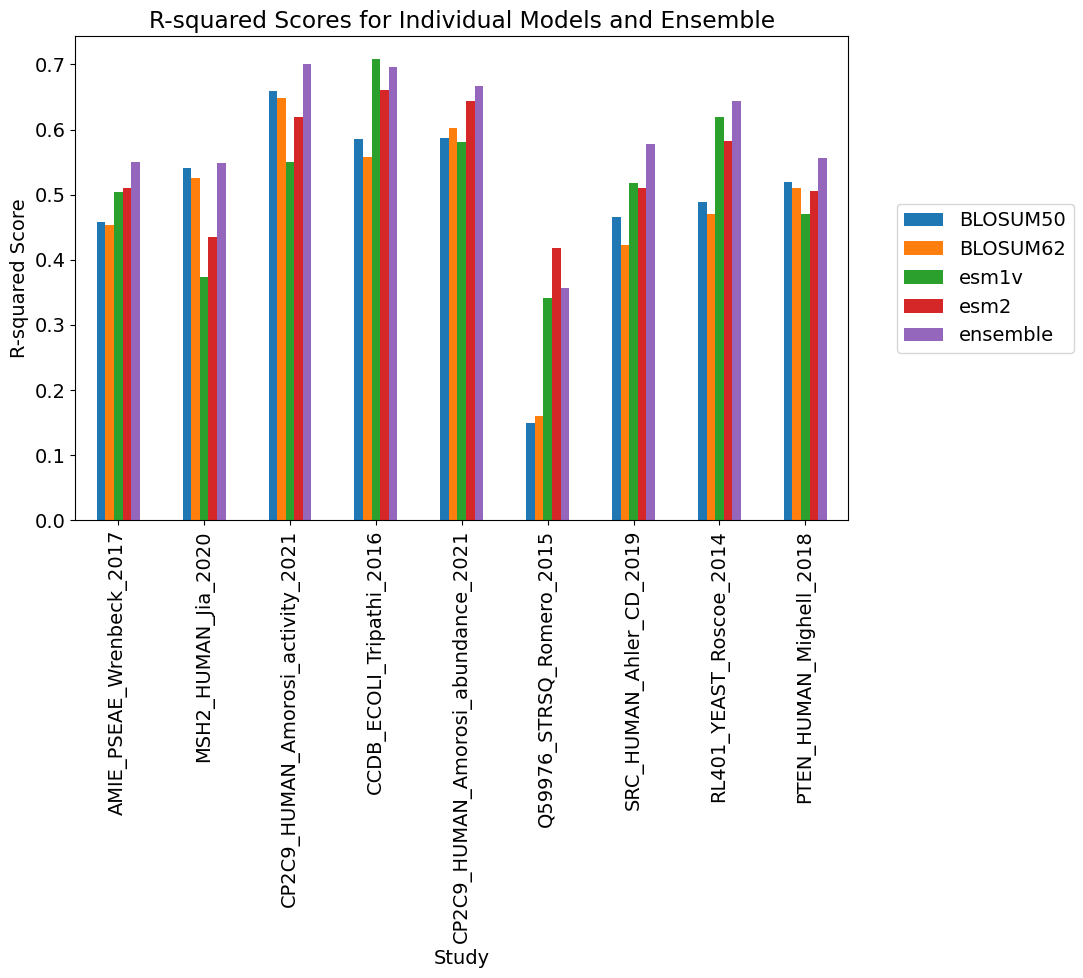

In [51]:
# Initialize a DataFrame to store the R-squared scores
r2_scores = pd.DataFrame(columns=selected_encoding_types + ['ensemble'])

# Calculate the R-squared scores
for dat, study_df in study_dfs.items():
    for et in selected_encoding_types:
        r2_scores.loc[dat, et] = r2_score(study_df['true'], study_df[et + '_predictions'])

    # Calculate the ensemble's predictions as the mean of the individual models' predictions
    study_df['ensemble_predictions'] = study_df[[et + '_predictions' for et in selected_encoding_types]].mean(axis=1)

    # Calculate the R-squared score for the ensemble's predictions
    r2_scores.loc[dat, 'ensemble'] = r2_score(study_df['true'], study_df['ensemble_predictions'])

# Plot the R-squared scores
ax = r2_scores.plot(kind='bar', figsize=(15, 10), y=r2_scores.columns)
plt.title('R-squared Scores for Individual Models and Ensemble')
plt.ylabel('R-squared Score')
plt.xlabel('Study')
plt.xticks(rotation=90)

# Position the legend outside of the plot, in the middle of the height
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout(rect=[0, 0, 0.75, 1])  # Ensure the legend is not clipped
plt.savefig('ensemble_performance.png')
plt.show()


In [37]:
def simulated_annealing(study_df, selected_encoding_types, T=10000, cooling_rate=0.995, min_T=0.01):
    # Initialize the current solution and the best solution
    current_solution = random.sample(selected_encoding_types, k=random.randint(1, len(selected_encoding_types)))
    best_solution = current_solution

    # Calculate the R-squared score for the current solution
    study_df['ensemble_predictions'] = study_df[[et + '_predictions' for et in current_solution]].mean(axis=1)
    current_r2_score = r2_score(study_df['true'], study_df['ensemble_predictions'])
    best_r2_score = current_r2_score

    # While the temperature is above the minimum temperature
    while T > min_T:
        # Generate a new solution by randomly adding or removing a model
        if random.random() < 0.5 and len(current_solution) < len(selected_encoding_types):
            # Add a model
            available_models = list(set(selected_encoding_types) - set(current_solution))
            new_solution = current_solution + [random.choice(available_models)]
        elif len(current_solution) > 1:
            # Remove a model
            new_solution = current_solution.copy()
            new_solution.remove(random.choice(new_solution))
        else:
            continue

        # Calculate the R-squared score for the new solution
        study_df['ensemble_predictions'] = study_df[[et + '_predictions' for et in new_solution]].mean(axis=1)
        new_r2_score = r2_score(study_df['true'], study_df['ensemble_predictions'])

        # If the new solution is better, accept it
        if new_r2_score > current_r2_score:
            current_solution = new_solution
            current_r2_score = new_r2_score

            # If the new solution is the best so far, update the best solution
            if new_r2_score > best_r2_score:
                best_solution = new_solution
                best_r2_score = new_r2_score
        else:
            # If the new solution is worse, accept it with a probability that decreases with the difference in R-squared scores and the temperature
            if random.random() < math.exp((new_r2_score - current_r2_score) / T):
                current_solution = new_solution
                current_r2_score = new_r2_score

        # Decrease the temperature
        T *= cooling_rate

    return best_solution, best_r2_score

# For each study, find the best ensemble of models using simulated annealing on the validation data
for dat, study_df in study_val_dfs.items():
    best_models, best_r2_score = simulated_annealing(study_df, selected_encoding_types)
    print(f'Study: {dat}, Best Models: {best_models}, Best R-squared Score: {best_r2_score}')

Study: AMIE_PSEAE_Wrenbeck_2017, Best Models: ['esm2', 'esm1v'], Best R-squared Score: 0.5551811513900191
Study: MSH2_HUMAN_Jia_2020, Best Models: ['esm1v', 'esm2'], Best R-squared Score: 0.45238543096491124
Study: CP2C9_HUMAN_Amorosi_activity_2021, Best Models: ['esm1v', 'esm2'], Best R-squared Score: 0.6514931499459686
Study: CCDB_ECOLI_Tripathi_2016, Best Models: ['esm1v', 'esm2'], Best R-squared Score: 0.7262426213184986
Study: CP2C9_HUMAN_Amorosi_abundance_2021, Best Models: ['esm2', 'esm1v'], Best R-squared Score: 0.6606587004967388
Study: Q59976_STRSQ_Romero_2015, Best Models: ['esm2', 'esm1v'], Best R-squared Score: 0.42935845432042385
Study: SRC_HUMAN_Ahler_CD_2019, Best Models: ['esm2', 'esm1v'], Best R-squared Score: 0.5873926812519062
Study: RL401_YEAST_Roscoe_2014, Best Models: ['esm1v', 'esm2'], Best R-squared Score: 0.6765333066727766
Study: PTEN_HUMAN_Mighell_2018, Best Models: ['esm1v', 'esm2'], Best R-squared Score: 0.52843666759788


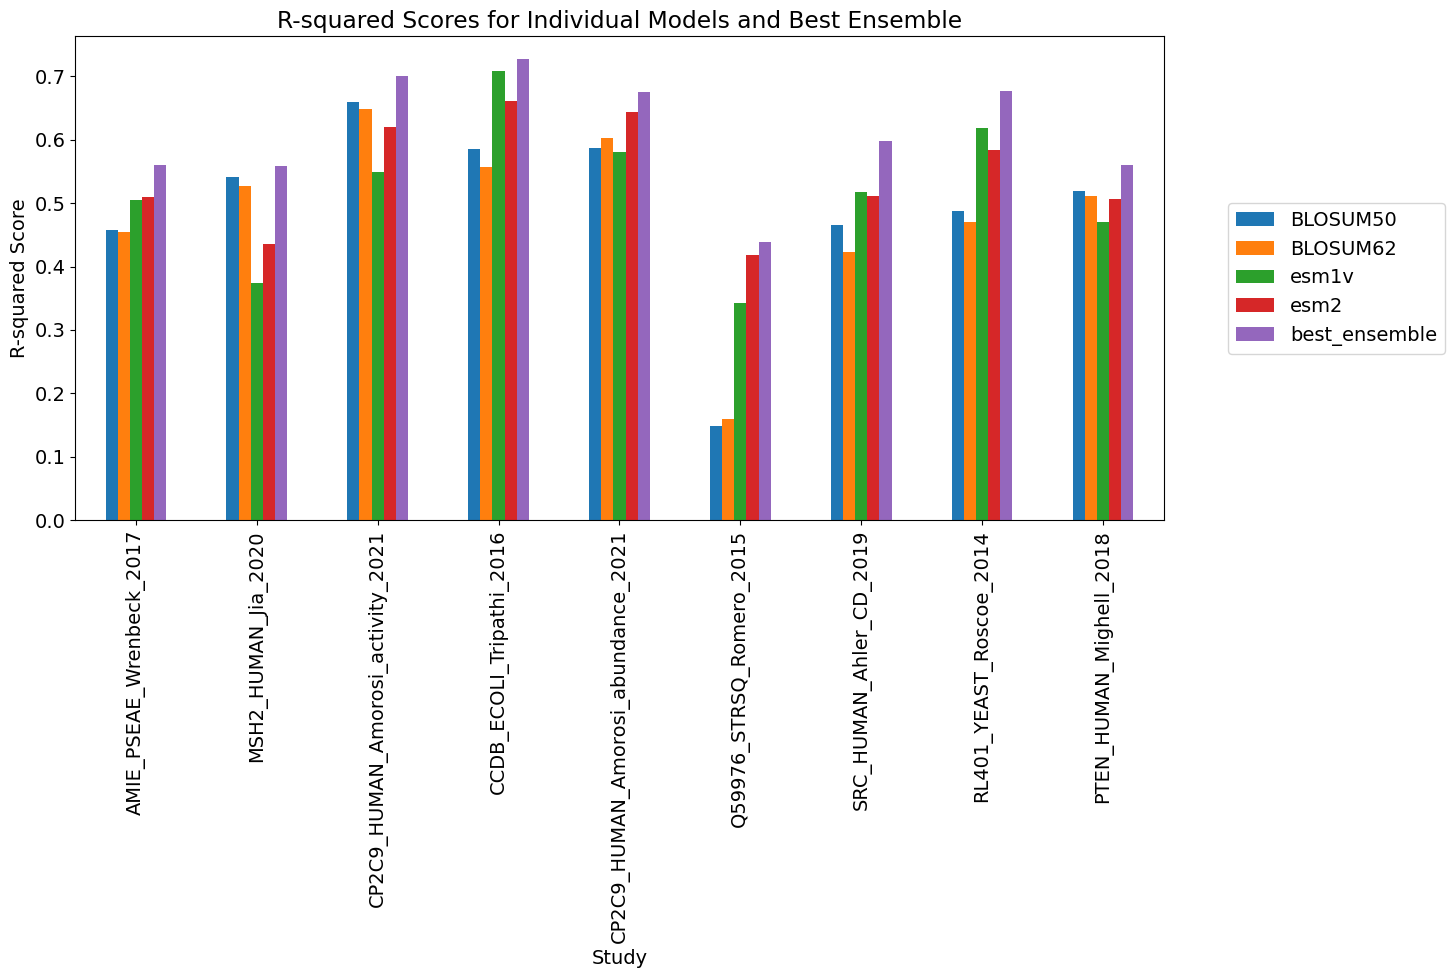

In [49]:
plt.rcParams['font.size'] = 14
# Initialize a DataFrame to store the R-squared scores
r2_scores = pd.DataFrame(columns=selected_encoding_types + ['best_ensemble'])
best_ensembles = {}  # Store the best ensembles for each study

# Calculate the R-squared scores
for dat, study_df in study_dfs.items():
    for et in selected_encoding_types:
        r2_scores.loc[dat, et] = r2_score(study_df['true'], study_df[et + '_predictions'])

    # Find the best ensemble using simulated annealing
    best_ensemble, _ = simulated_annealing(study_df, selected_encoding_types)
    best_ensembles[dat] = best_ensemble  # Store the best ensemble

    # Calculate the ensemble's predictions as the mean of the best models' predictions
    study_df['best_ensemble_predictions'] = study_df[[et + '_predictions' for et in best_ensemble]].mean(axis=1)

    # Calculate the R-squared score for the best ensemble's predictions
    r2_scores.loc[dat, 'best_ensemble'] = r2_score(study_df['true'], study_df['best_ensemble_predictions'])

# Plot the R-squared scores
r2_scores = r2_scores.reindex(columns=selected_encoding_types + ['best_ensemble'])  # Ensure the order of the columns
ax = r2_scores.plot(kind='bar', figsize=(20, 10))
plt.title('R-squared Scores for Individual Models and Best Ensemble')
plt.ylabel('R-squared Score')
plt.xlabel('Study')
plt.xticks(rotation=90)

# Add text to the ensemble bars
for i, dat in enumerate(r2_scores.index):
    ensemble_models = ', '.join(best_ensembles[dat])

# Position the legend outside of the plot, in the middle of the height
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout(rect=[0, 0, 0.75, 1])  # Ensure the legend is not clipped
plt.savefig('best_ensemble_performance.png')
plt.show()


In [100]:
# Initialize a DataFrame to store the R-squared scores and the best ensembles
results = pd.DataFrame(columns=selected_encoding_types + ['best_ensemble', 'best_ensemble_models'])

# Calculate the R-squared scores
for dat, study_df in study_dfs.items():
    for et in selected_encoding_types:
        results.loc[dat, et] = r2_score(study_df['true'], study_df[et + '_predictions'])

    # Find the best ensemble using simulated annealing
    best_ensemble, _ = simulated_annealing(study_df, selected_encoding_types)

    # Calculate the ensemble's predictions as the mean of the best models' predictions
    study_df['best_ensemble_predictions'] = study_df[[et + '_predictions' for et in best_ensemble]].mean(axis=1)

    # Calculate the R-squared score for the best ensemble's predictions
    results.loc[dat, 'best_ensemble'] = r2_score(study_df['true'], study_df['best_ensemble_predictions'])

    # Store the models used in the best ensemble
    results.loc[dat, 'best_ensemble_models'] = ', '.join(best_ensemble)

# Print the results
print(results.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &  BLOSUM50 &  BLOSUM62 &     esm1v &      esm2 & best\_ensemble &             best\_ensemble\_models \\
\midrule
AMIE\_PSEAE\_Wrenbeck\_2017           &  0.457384 &  0.454109 &  0.504298 &  0.510072 &      0.560756 &            BLOSUM62, esm1v, esm2 \\
MSH2\_HUMAN\_Jia\_2020                &  0.541588 &  0.526386 &  0.373815 &  0.435776 &      0.559223 &         BLOSUM62, BLOSUM50, esm2 \\
CP2C9\_HUMAN\_Amorosi\_activity\_2021  &  0.658713 &  0.648056 &  0.549741 &  0.619343 &      0.700723 &  esm2, esm1v, BLOSUM50, BLOSUM62 \\
CCDB\_ECOLI\_Tripathi\_2016           &  0.585195 &  0.557489 &  0.707837 &  0.660215 &       0.72661 &                      esm2, esm1v \\
CP2C9\_HUMAN\_Amorosi\_abundance\_2021 &  0.587191 &  0.602622 &  0.580432 &  0.644189 &      0.675689 &                   BLOSUM62, esm2 \\
Q59976\_STRSQ\_Romero\_2015           &  0.149009 &  0.160306 &  0.341879 &  0.418259 &      0.439449 &                      esm1v, esm2 \\
SRC\_HU

/var/folders/sd/pr3fylj57wlgrmcxg1v4zp3c0000gn/T/ipykernel_51018/1028707416.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex())


In [40]:
# Convert the numeric results to strings with 4 decimal places
formatted_results = results.applymap(lambda x: f'{x:.2f}' if isinstance(x, float) else x)

# Print the formatted results to LaTeX
print(formatted_results.to_latex())

\begin{tabular}{lllllll}
\toprule
{} & BLOSUM50 & BLOSUM62 & esm1v &  esm2 & best\_ensemble &             best\_ensemble\_models \\
\midrule
AMIE\_PSEAE\_Wrenbeck\_2017           &     0.46 &     0.45 &  0.50 &  0.51 &          0.56 &            esm1v, esm2, BLOSUM62 \\
MSH2\_HUMAN\_Jia\_2020                &     0.54 &     0.53 &  0.37 &  0.44 &          0.56 &         BLOSUM50, esm2, BLOSUM62 \\
CP2C9\_HUMAN\_Amorosi\_activity\_2021  &     0.66 &     0.65 &  0.55 &  0.62 &          0.70 &  BLOSUM62, BLOSUM50, esm2, esm1v \\
CCDB\_ECOLI\_Tripathi\_2016           &     0.59 &     0.56 &  0.71 &  0.66 &          0.73 &                      esm1v, esm2 \\
CP2C9\_HUMAN\_Amorosi\_abundance\_2021 &     0.59 &     0.60 &  0.58 &  0.64 &          0.68 &                   BLOSUM62, esm2 \\
Q59976\_STRSQ\_Romero\_2015           &     0.15 &     0.16 &  0.34 &  0.42 &          0.44 &                      esm2, esm1v \\
SRC\_HUMAN\_Ahler\_CD\_2019            &     0.47 &     0.42 &  0.52 &  0.51 

/var/folders/sd/pr3fylj57wlgrmcxg1v4zp3c0000gn/T/ipykernel_51018/1530993203.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(formatted_results.to_latex())


In [101]:
vals = results.iloc[:, 0:5].values

In [115]:
r = np.max(vals, axis=1) - np.partition(vals, -2, axis=1)[:, -2]
r = [round(x, 2) for x in r]
results['delta'] = list(r)

In [116]:
print(results.iloc[:,-1].to_latex())


\begin{tabular}{lr}
\toprule
{} &  delta \\
\midrule
AMIE\_PSEAE\_Wrenbeck\_2017           &   0.05 \\
MSH2\_HUMAN\_Jia\_2020                &   0.02 \\
CP2C9\_HUMAN\_Amorosi\_activity\_2021  &   0.04 \\
CCDB\_ECOLI\_Tripathi\_2016           &   0.02 \\
CP2C9\_HUMAN\_Amorosi\_abundance\_2021 &   0.03 \\
Q59976\_STRSQ\_Romero\_2015           &   0.02 \\
SRC\_HUMAN\_Ahler\_CD\_2019            &   0.08 \\
RL401\_YEAST\_Roscoe\_2014            &   0.06 \\
PTEN\_HUMAN\_Mighell\_2018            &   0.04 \\
\bottomrule
\end{tabular}



/var/folders/sd/pr3fylj57wlgrmcxg1v4zp3c0000gn/T/ipykernel_51018/3484391452.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.iloc[:,-1].to_latex())


In [109]:
results

BLOSUM50  BLOSUM62     esm1v      esm2  \
AMIE_PSEAE_Wrenbeck_2017            0.457384  0.454109  0.504298  0.510072   
MSH2_HUMAN_Jia_2020                 0.541588  0.526386  0.373815  0.435776   
CP2C9_HUMAN_Amorosi_activity_2021   0.658713  0.648056  0.549741  0.619343   
CCDB_ECOLI_Tripathi_2016            0.585195  0.557489  0.707837  0.660215   
CP2C9_HUMAN_Amorosi_abundance_2021  0.587191  0.602622  0.580432  0.644189   
Q59976_STRSQ_Romero_2015            0.149009  0.160306  0.341879  0.418259   
SRC_HUMAN_Ahler_CD_2019             0.465422  0.422948  0.518205  0.511016   
RL401_YEAST_Roscoe_2014             0.488083  0.470968  0.618615  0.582988   
PTEN_HUMAN_Mighell_2018             0.519737  0.510667  0.470664  0.506147   

                                   best_ensemble  \
AMIE_PSEAE_Wrenbeck_2017                0.560756   
MSH2_HUMAN_Jia_2020                     0.559223   
CP2C9_HUMAN_Amorosi_activity_2021       0.700723   
CCDB_ECOLI_Tripathi_2016                 0.72661   
CP2C9_HUMAN_Amorosi_abundance_2021      0.675689   
Q59976_STRSQ_Romero_2015                0.439449   
SRC_HUMAN_Ahler_CD_2019                 0.598048   
RL401_YEAST_Roscoe_2014                 0.676533   
PTEN_HUMAN_Mighell_2018                 0.559457   

                                               best_ensemble_models     delta  
AMIE_PSEAE_Wrenbeck_2017                      BLOSUM62, esm1v, esm2  0.050684  
MSH2_HUMAN_Jia_2020                        BLOSUM62, BLOSUM50, esm2  0.017635  
CP2C9_HUMAN_Amorosi_activity_2021   esm2, esm1v, BLOSUM50, BLOSUM62  0.042009  
CCDB_ECOLI_Tripathi_2016                                esm2, esm1v  0.018773  
CP2C9_HUMAN_Amorosi_abundance_2021                   BLOSUM62, esm2  0.031499  
Q59976_STRSQ_Romero_2015                                esm1v, esm2  0.021190  
SRC_HUMAN_Ahler_CD_2019                       esm2, BLOSUM50, esm1v  0.079843  
RL401_YEAST_Roscoe_2014                                 esm1v, esm2  0.057918  
PTEN_HUMAN_Mighell_2018                              esm2, BLOSUM50  0.039720